In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,gpflow,GPy,tensorflow,tensorflow_probability

cs224 
last updated: 2020-04-25 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
gpflow 2.0.1
GPy 1.9.9
tensorflow 2.1.0
tensorflow_probability 0.9.0


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

In [5]:
df_   = pd.read_csv('https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data')

In [6]:
df_.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen
0,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476974,2020-03-17T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-17T00:00:00.000Z,0,1
1,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476975,2020-03-18T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-16T00:00:00.000Z,0,1
2,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476976,2020-03-18T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-18T00:00:00.000Z,0,1
3,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476977,2020-03-19T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-07T00:00:00.000Z,0,1
4,1,Schleswig-Holstein,LK Pinneberg,A35-A59,M,1,0,3476978,2020-03-19T00:00:00.000Z,1056,"24.04.2020, 00:00 Uhr",0,-9,2020-03-13T00:00:00.000Z,0,1


In [7]:
df_['AnzahlFall'].sum()

150316

In [8]:
lds = df_['Bundesland']
len(lds.unique()), lds.unique()

(16,
 array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Nordrhein-Westfalen', 'Bremen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Thüringen', 'Sachsen-Anhalt'], dtype=object))

In [9]:
def timeline(in_df, state=None, county=None, time_anchor_column_name='Refdatum', count_column_name='AnzahlFall'):
    ldf = in_df.copy()
    if state is not None:
        ldf = ldf[ldf['Bundesland'] == state].copy()
    if county is not None:
        ldf = ldf[ldf['Landkreis'] == county].copy()
    ldf[time_anchor_column_name] = pd.to_datetime(ldf[time_anchor_column_name]).dt.tz_localize(None)
    ldf = ldf.set_index(time_anchor_column_name)
    ldf.index.name = 'index'
    lds = ldf[count_column_name].resample('D').sum()
    return lds

In [10]:
def create_rki_df(in_df, state=None, county=None, time_anchor_column_name='Meldedatum'):
    lds_confirmed = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlFall')
    lds_recovered = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlGenesen')
    lds_death     = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlTodesfall')
    ldf = pd.DataFrame()
    ldf['confirmed'] = lds_confirmed.cumsum()
    ldf['recovered'] = lds_recovered.cumsum()
    ldf['death']     = lds_death.cumsum()
    
    ldf['new_confirmed'] = lds_confirmed
    ldf['new_recovered'] = lds_recovered
    ldf['new_death']     = lds_death
    return ldf

In [11]:
# create_rki_df(df_)

In [12]:
cbr_germany = covid19.CasesByRegion('Germany', df=create_rki_df(df_))
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-19,143386,106178,5227,1373,152,26
2020-04-20,145097,106353,5265,1711,175,38
2020-04-21,147220,106518,5293,2123,165,28
2020-04-22,149456,106616,5316,2236,98,23
2020-04-23,150316,106658,5318,860,42,2


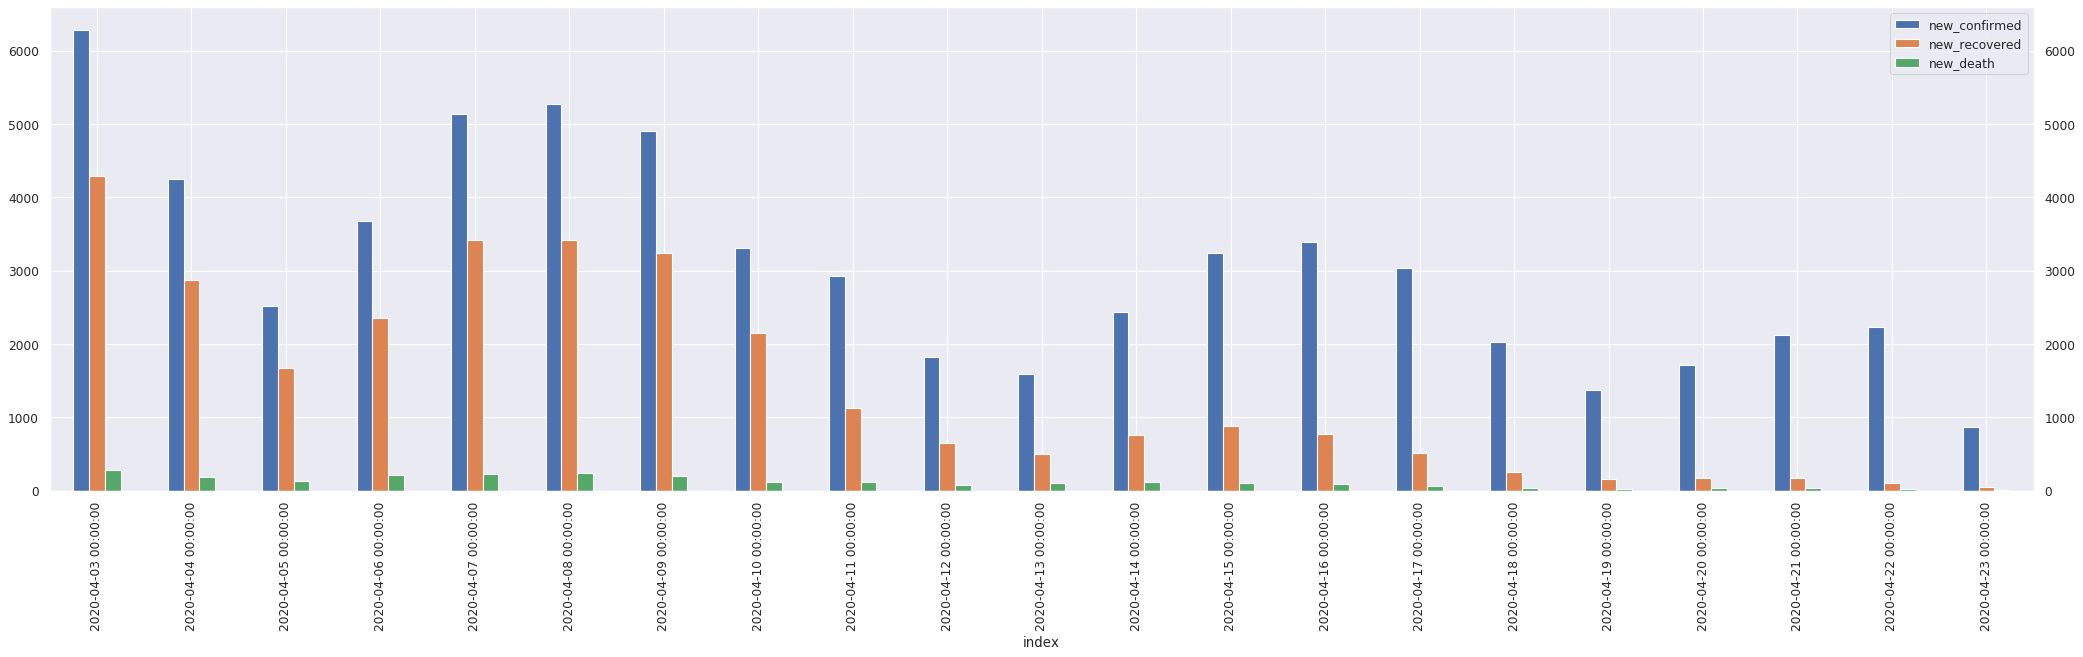

In [13]:
cbr_germany.plot_daily_stats()

sigmoid+linear 2020-07-31 00:00:00 [101246.53930034      0.18403068    -11.20096323  10676.75214898] 0.014097659602768875 1964.8500041206971


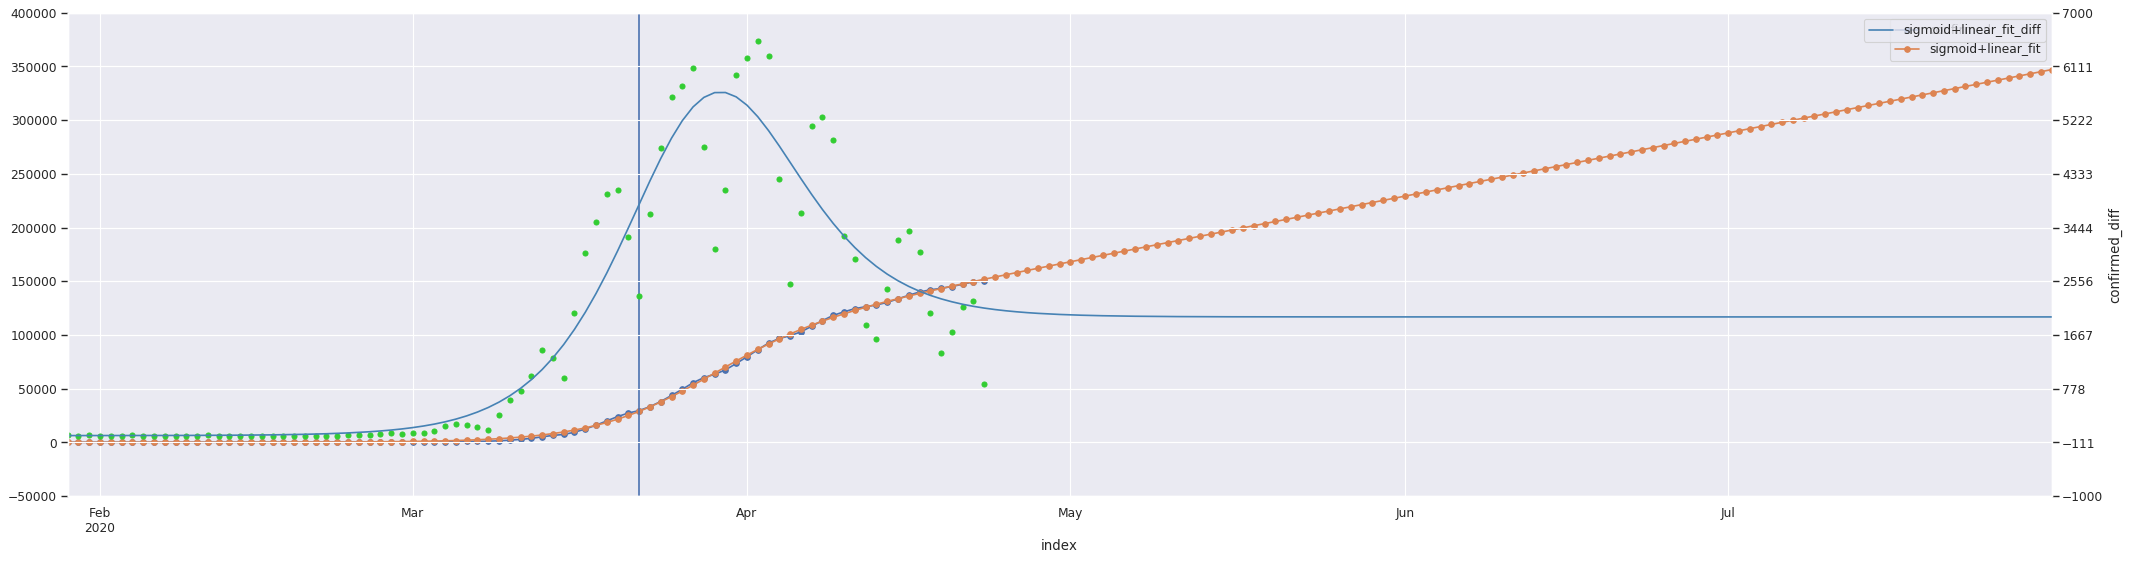

In [14]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add, range_append_nr_entires=100)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [15]:
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff
index,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0
2020-01-29,2.0,4.0,2.209240,0.371345,2.0
2020-01-30,3.0,4.0,2.655612,0.446373,0.0
2020-01-31,4.0,8.0,3.192171,0.536559,4.0
2020-02-01,5.0,8.0,3.837137,0.644966,0.0
...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN


In [16]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,5680.268541


In [17]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

860.0

In [18]:
ldf.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff
index,,,,,
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN
2020-07-30,185.0,NaN,345153.881833,1964.850006,NaN
2020-07-31,186.0,NaN,347118.731838,1964.850006,NaN


In [19]:
lpopt

array([101246.53930034,      0.18403068,    -11.20096323,  10676.75214898])

In [20]:
def discrete_diff(in_da, first_value=np.nan):
    in_da = np.array(in_da)
    return np.concatenate([np.array([first_value]), in_da[1:] - in_da[:-1]])

In [21]:
lda = covid19.fitSig(ldf.x, *lpopt[:-1]).values
ldf['pure_sig_fit'] = lda
ldf['pure_sig_fit_diff'] = discrete_diff(lda)
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff
index,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439
...,...,...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003


In [22]:
ldf['pure_sig_fit_diff'].describe()

count     185.000000
mean      547.269604
std      1186.029663
min         0.000002
25%         0.009684
50%         3.673548
75%       246.457017
max      4649.608065
Name: pure_sig_fit_diff, dtype: float64

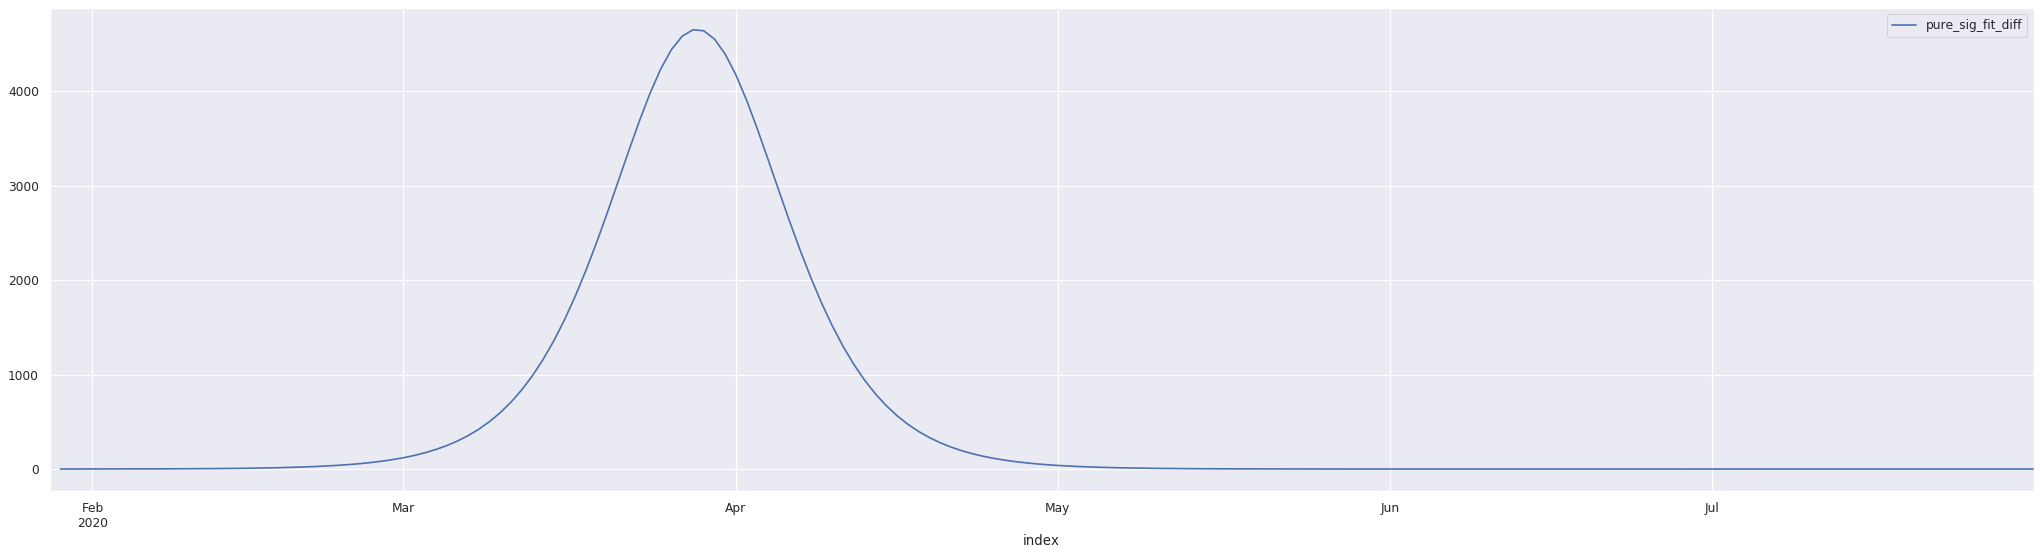

In [23]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['pure_sig_fit_diff']].plot(ax=ax)

In [135]:
def calculate_R_from_fit_diff(in_df, fit_diff_column_name):
    rdf = pd.DataFrame(index=in_df.index)
    
    average_infectious_period = 7.0
    gamma = 1 / average_infectious_period
    ws = 7
    rdf['v'] = in_df[fit_diff_column_name]
    rdf['I_t'] = in_df[fit_diff_column_name].rolling(window=ws).sum()#, min_periods=1
    lds = rdf['I_t']
    lda_delta_It = lds.values[1:] - lds.values[:-1]
    rdf['dI_t'] = np.concatenate([np.array([np.nan]), lda_delta_It])
    lda_gr_It = lda_delta_It / lds.values[:-1]
    lda_gr_It = np.concatenate([np.array([np.nan]), lda_gr_It])
    rdf['gr_It'] = lda_gr_It
    lda_R = np.maximum(1.0 + 1/gamma * lda_gr_It,0.0)
    rdf['R_t'] = lda_R
    return rdf

R_t    0.0
Name: 2020-04-23 00:00:00, dtype: float64

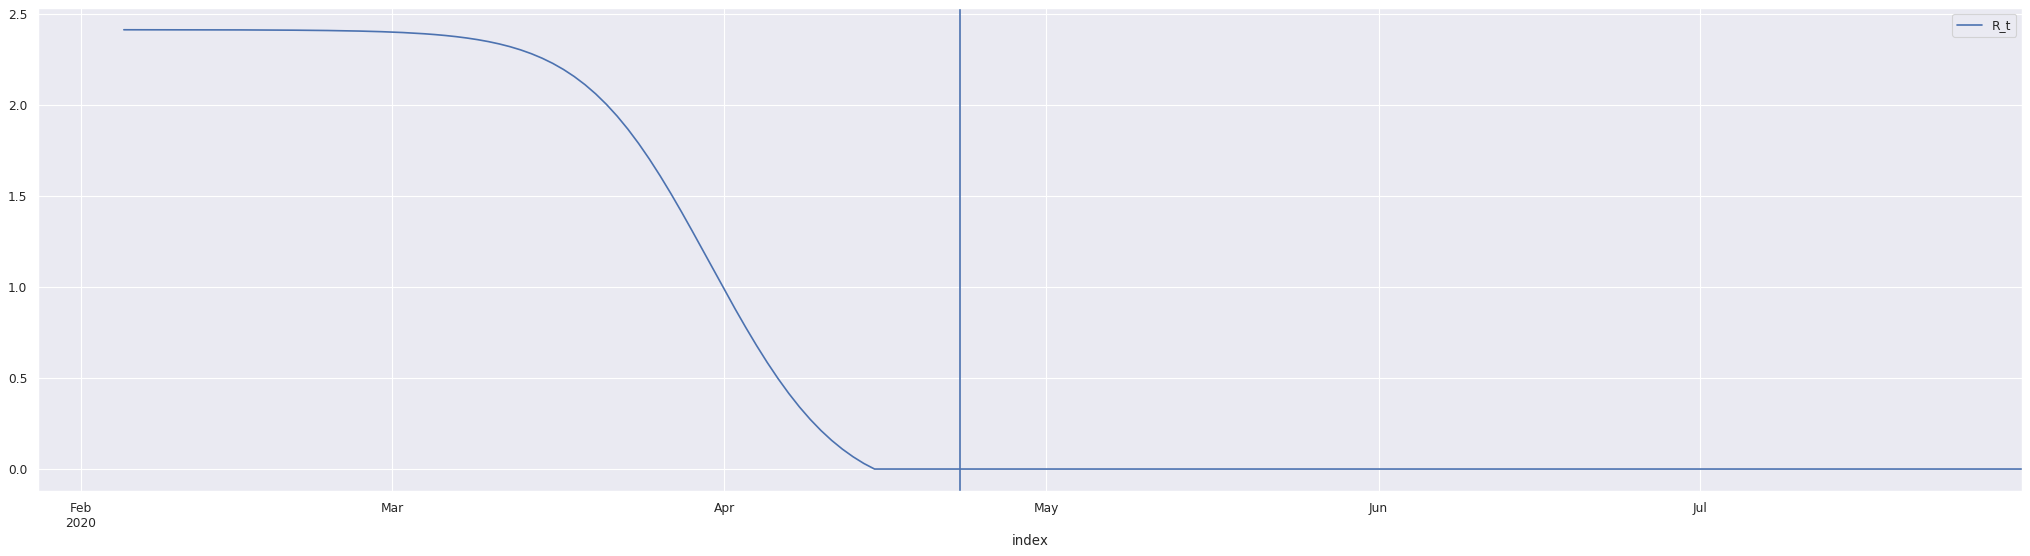

In [25]:
# ldf_R = calculate_R_from_fit_diff(ldf, label + '_fit_diff')
ldf_R = calculate_R_from_fit_diff(ldf, 'pure_sig_fit_diff')
# ldf_R_pure_sig_fit_diff.iloc[-20:]

fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
dt = cbr_germany.df.index[-1]
ax.axvline(dt);
ldf_R[['R_t']].loc[dt]

In [26]:
# ldf_R_pure_sig_fit_diff.to_excel('ldf_R_pure_sig_fit_diff.xlsx')

In [27]:
# average_infectious_period = 7.0
# gamma = 1 / average_infectious_period
# ws = 7
# ldf['I_t'] = ldf[label + '_fit_diff'] .rolling(window=ws).sum()#, min_periods=1
# lds = ldf['I_t']
# delta_It = lds.values[1:] - lds.values[:-1]
# gr_It = delta_It / lds.values[:-1]
# gr_It = np.concatenate([np.array([np.nan]), gr_It])
# ldf['gr_It'] = gr_It
# R = 1.0 + 1/gamma * gr_It
# ldf['R_t'] = R

In [28]:
ldf.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff
index,,,,,,,
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003
2020-07-30,185.0,NaN,345153.881833,1964.850006,NaN,101246.539288,0.000002
2020-07-31,186.0,NaN,347118.731838,1964.850006,NaN,101246.539290,0.000002


In [29]:
import gpflow

* [GPflow_work](https://github.com/NuhaSaud/GPflow_work) : Practical_considerations.ipynb
    * [Random restarts for hyperparameter optimization](https://github.com/GPflow/GPflow/issues/1002)

In [30]:
ldf1 = ldf.loc[:cbr_germany.df.index[-2]]
ldf1.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff
index,,,,,,,
2020-04-18,82.0,142013.0,140961.080213,2321.908722,2025.0,99217.104085,400.212699
2020-04-19,83.0,143386.0,143225.316193,2264.235979,1373.0,99552.523688,335.419603
2020-04-20,84.0,145097.0,145440.868503,2215.552310,1711.0,99833.295685,280.771997
2020-04-21,85.0,147220.0,147615.425279,2174.556776,2123.0,100068.082435,234.786750
2020-04-22,86.0,149456.0,149755.530662,2140.105384,2236.0,100264.247092,196.164656


In [31]:
X = ldf1.x.values.reshape(-1,1)
Y = (ldf1.confirmed - ldf1[label + '_fit']).values.reshape(-1,1)
# Y = ldf1.confirmed.values.reshape(-1,1)

k1 = gpflow.kernels.RBF(variance=60.0, lengthscales=140.0)

k2 = gpflow.kernels.RBF(variance=1.0, lengthscales=7.0) * gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(variance=1.0,  lengthscales=0.5), period=7.0)

kernel = k1 + k2

m = gpflow.models.GPR(data=(X, Y), kernel=kernel, noise_variance=1.0)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss,variables=m.trainable_variables,options=dict(disp=True), compile=False) #'Nelder-Mead', method='trust-exact', , maxiter=30

      fun: 622.0885733395279
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000001,  0.00000208,  0.00006324, -0.00000007, -0.00004863, -0.00000007, -0.00004538, -0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 71
      nit: 54
   status: 0
  success: True
        x: array([ 139.85213671,   60.96013149,    6.24423637, 1252.21039804,    0.47143471, 1252.21039804,    6.85852985, -252.53213529])

In [32]:
m

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,60.9601
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,139.852
GPR.kernel.kernels[1].kernels[0].variance,Parameter,Softplus,,True,(),float64,1252.21
GPR.kernel.kernels[1].kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,6.24618
GPR.kernel.kernels[1].kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,1252.21
GPR.kernel.kernels[1].kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.956392
GPR.kernel.kernels[1].kernels[1].period,Parameter,Softplus,,True,(),float64,6.85958
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


In [33]:
# mean, variance = m.predict_f(X)
# mean.numpy()

In [34]:
ldf['confirmed_' + label + '_fit_delta'] = ldf1.confirmed - ldf1[label + '_fit']
ldf['gp_fit_'] = m.predict_f(ldf.x.values.reshape(-1,1))[0].numpy().reshape(-1)
ldf['gp_fit'] = ldf[label + '_fit'] + ldf['gp_fit_']
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit
index,,,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,0.162105,0.162105,2.000000
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,1.790760,1.790760,4.000000
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,1.344388,1.344388,4.000000
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,4.807829,4.807829,8.000000
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,4.162863,4.162863,8.000000
...,...,...,...,...,...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004,NaN,-0.033683,339259.298129
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004,NaN,-0.033421,341224.148399
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003,NaN,-0.033158,343188.998668


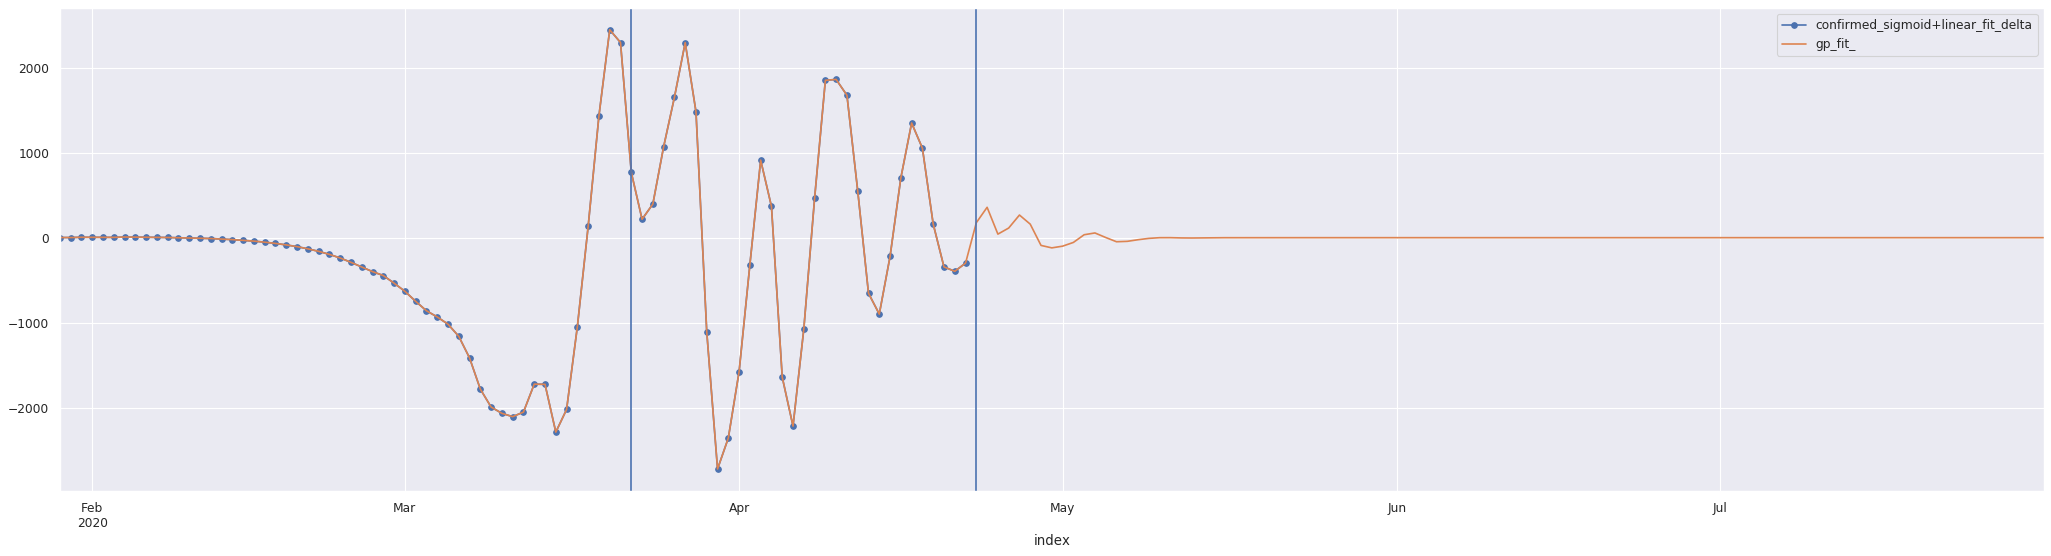

In [35]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed_' + label + '_fit_delta']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ldf[['gp_fit_']].iloc[1:,:].plot(ax=ax);
ax.axvline(restriction_start_date);
dt = cbr_germany.df.index[-1]
ax.axvline(dt);

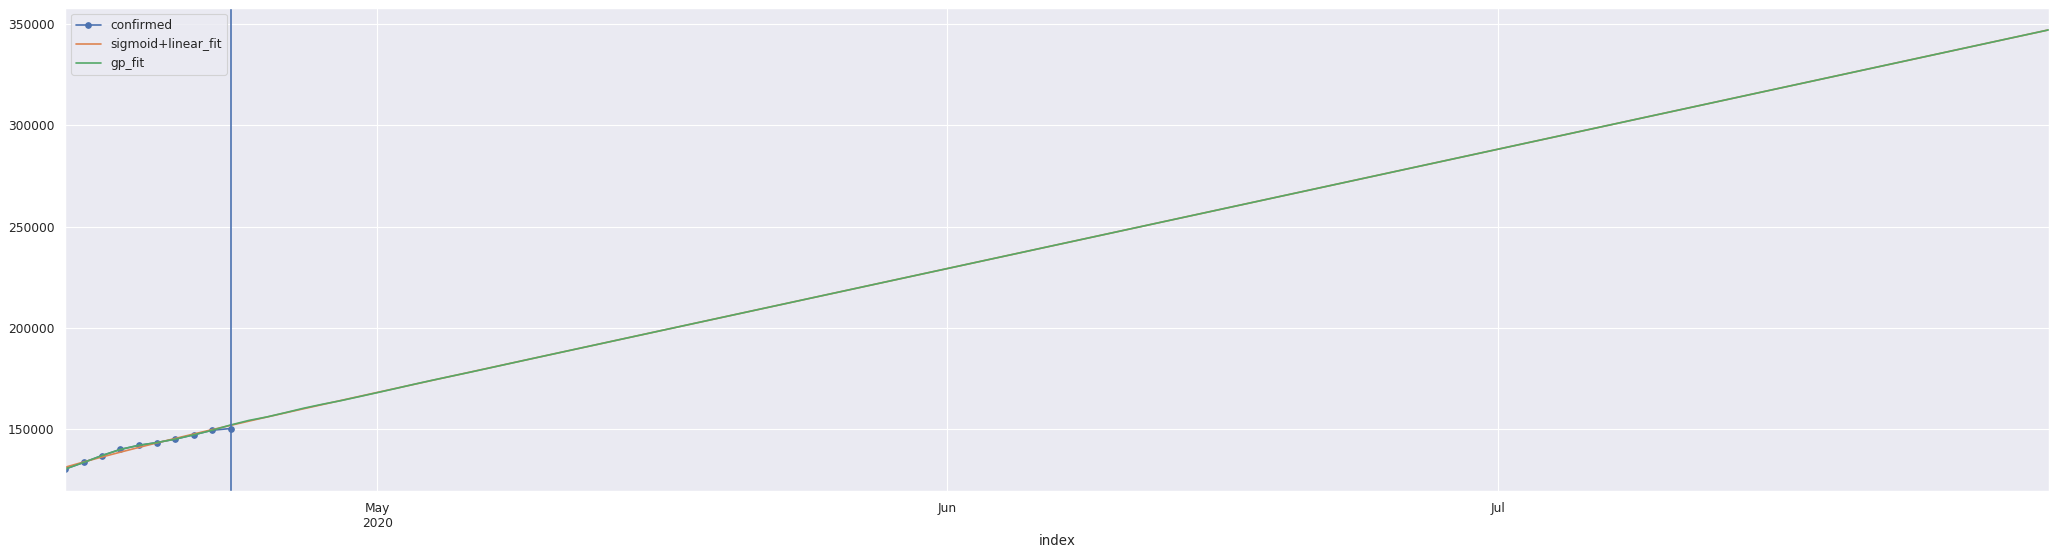

In [36]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
dt = cbr_germany.df.index[-1]
dt1 = dt + pd.DateOffset(-10)
ldf1 = ldf.loc[dt1:].copy()
ldf1[['confirmed']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ldf1[[label + '_fit', 'gp_fit']].iloc[1:,:].plot(ax=ax);
ax.axvline(restriction_start_date);

ax.axvline(dt);

In [37]:
import GPy, IPython.display

In [38]:
k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=7.)
# k2_exp_sine_squred_gamma= 2.0 / 1.3 ** 2.0
# k2_exp_sine_squred_period = 7.0
# k2 = GPy.kern.RBF(input_dim=1, variance=(2.4 ** 2.0), lengthscale=30.0) * GPy.kern.PeriodicExponential(input_dim=1, period=k2_exp_sine_squred_period, variance=1.0,  lengthscale=1.0/k2_exp_sine_squred_gamma)
# k2 = GPy.kern.PeriodicExponential(input_dim=1, period=k2_exp_sine_squred_period, variance=1.0,  lengthscale=1.0/k2_exp_sine_squred_gamma)
k2 = GPy.kern.PeriodicExponential(input_dim=1, period=7.0, variance=1.0,  lengthscale=1.0)
k3 = GPy.kern.RBF(1, variance=(0.18 ** 2), lengthscale=1.0) + GPy.kern.White(1, variance=0.19)
# kernel = k1 + k2 + k3
kernel = k1 + k2 # + k2 # + k3

In [39]:
X = ldf1.x.values.reshape(-1,1)
Y = (ldf1.confirmed - ldf1[label + '_fit']  ).values.reshape(-1,1)
m = GPy.models.GPRegression(X,Y,kernel)
m

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,7.0,+ve,
sum.periodic_exponential.variance,1.0,+ve,
sum.periodic_exponential.lengthscale,1.0,+ve,
sum.periodic_exponential.period,7.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [40]:
m.optimize_restarts(num_restarts = 10, robust=True)

Warning - optimization restart 1/10 failed
Warning - optimization restart 2/10 failed
Warning - optimization restart 3/10 failed
Warning - optimization restart 4/10 failed
Warning - optimization restart 5/10 failed
Warning - optimization restart 6/10 failed
Warning - optimization restart 7/10 failed
Warning - optimization restart 8/10 failed
Warning - optimization restart 9/10 failed
Warning - optimization restart 10/10 failed


[]

GP_regression.,value,constraints,priors
sum.rbf.variance,1.0,+ve,
sum.rbf.lengthscale,7.0,+ve,
sum.periodic_exponential.variance,1.0,+ve,
sum.periodic_exponential.lengthscale,1.0,+ve,
sum.periodic_exponential.period,7.0,+ve,
Gaussian_noise.variance,1.0,+ve,


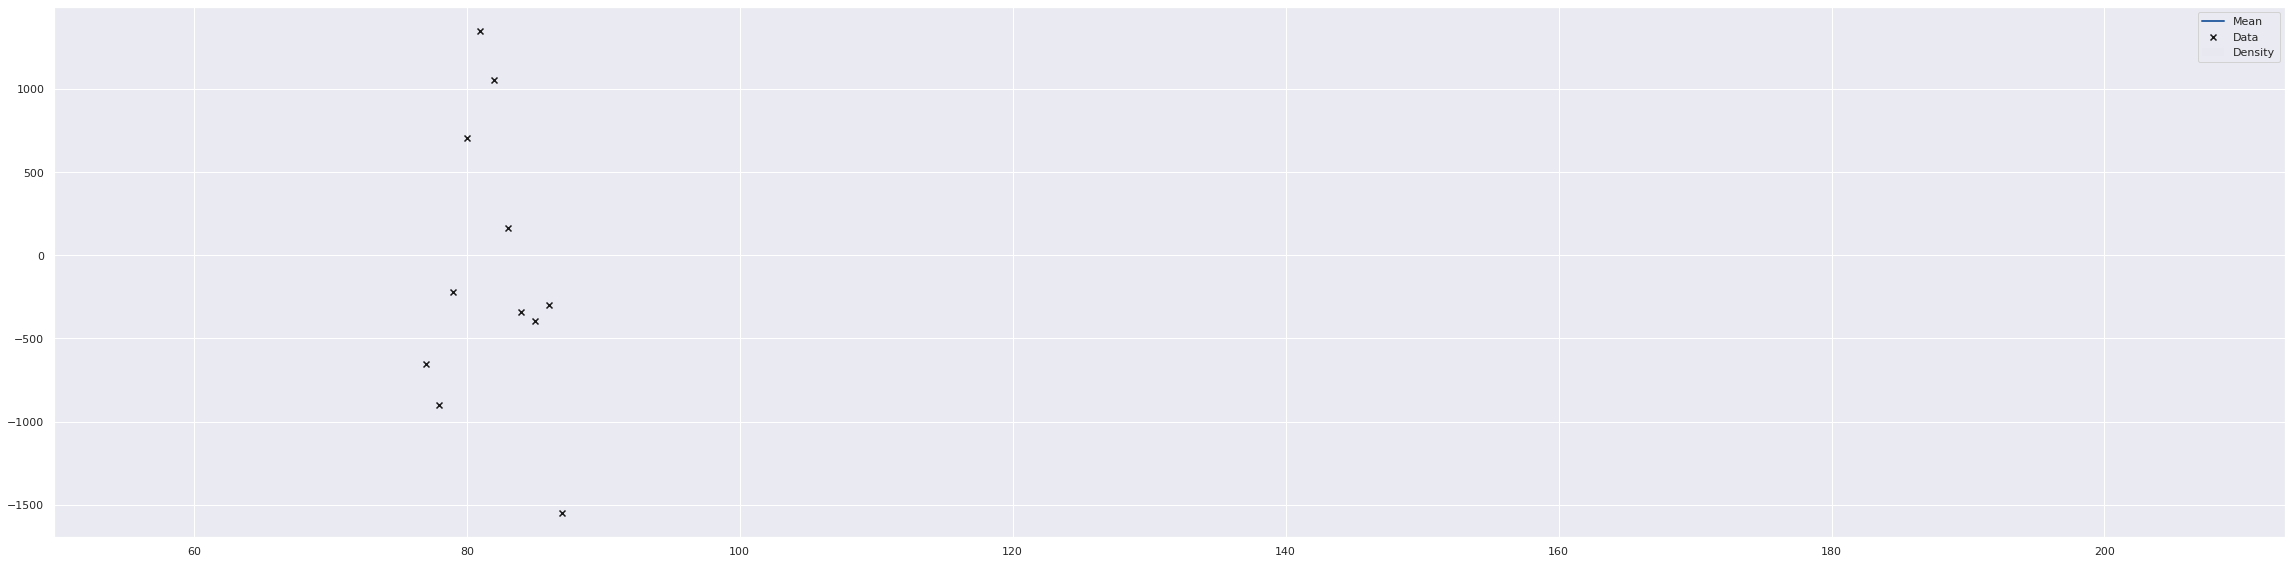

In [41]:
display(m)
fig = m.plot(plot_density=True, figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
#GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [42]:
ldf['gp_fit'] = m.predict(ldf.x.values.reshape(-1,1))[0].reshape(-1)
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit
index,,,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,0.162105,0.162105,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,1.790760,1.790760,NaN
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,1.344388,1.344388,NaN
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,4.807829,4.807829,NaN
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,4.162863,4.162863,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004,NaN,-0.033683,NaN
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004,NaN,-0.033421,NaN
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003,NaN,-0.033158,NaN


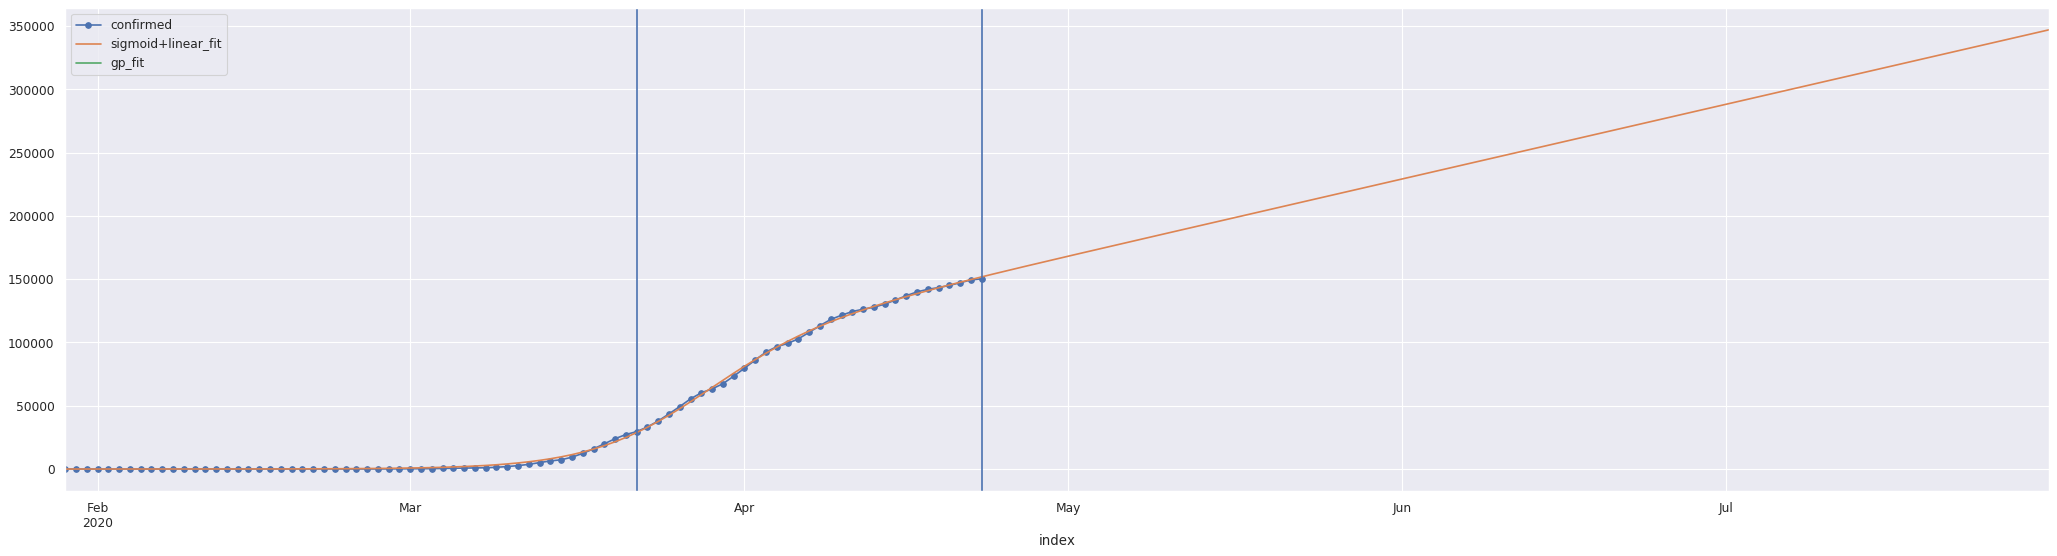

In [43]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ldf[[label + '_fit', 'gp_fit']].iloc[1:,:].plot(ax=ax);
ax.axvline(restriction_start_date);
dt = cbr_germany.df.index[-1]
ax.axvline(dt);

In [44]:
import filterpy, filterpy.kalman
filterpy.__version__

'1.4.5'

In [45]:
kf = filterpy.kalman.KalmanFilter(dim_x=1, dim_z=1)

In [46]:
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit
index,,,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,0.162105,0.162105,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,1.790760,1.790760,NaN
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,1.344388,1.344388,NaN
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,4.807829,4.807829,NaN
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,4.162863,4.162863,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004,NaN,-0.033683,NaN
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004,NaN,-0.033421,NaN
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003,NaN,-0.033158,NaN


In [47]:
cn = label + '_fit'
cn

'sigmoid+linear_fit'

In [48]:
lpopt

array([101246.53930034,      0.18403068,    -11.20096323,  10676.75214898])

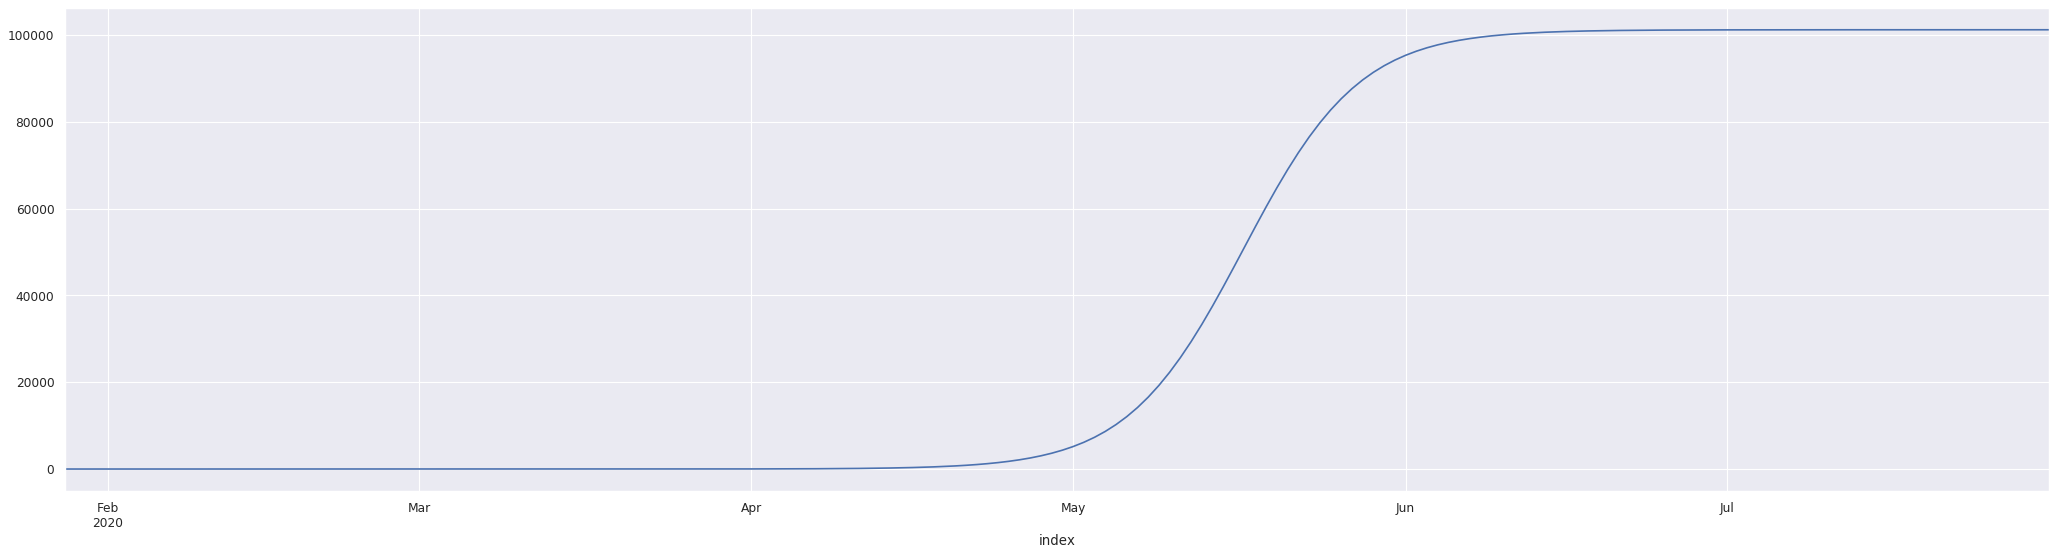

In [49]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
covid19.fitSig(ldf.x-50, *lpopt[:3]).plot(ax=ax)

In [50]:
ldf['test_data'] = ldf[cn] + covid19.fitSig(ldf.x-50, *lpopt[:3])

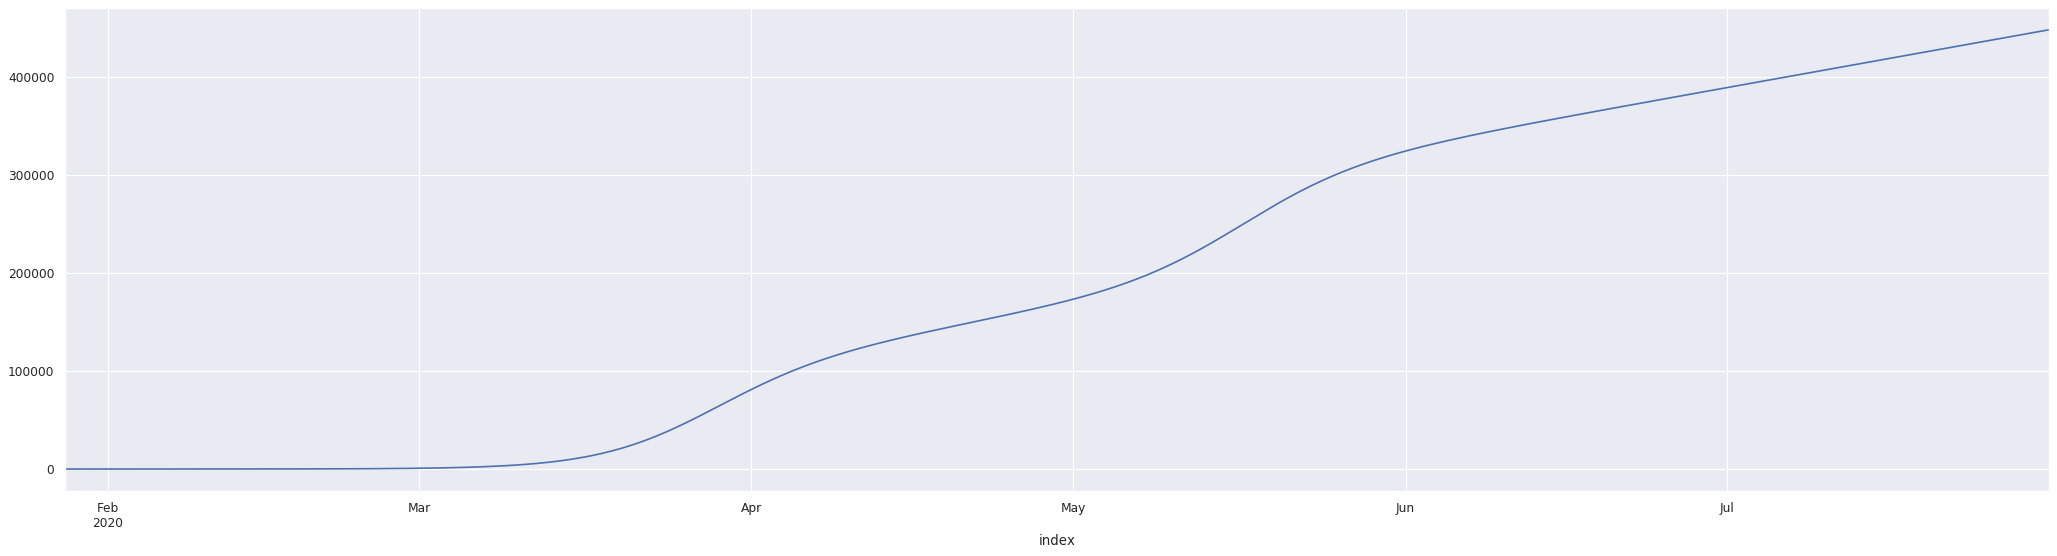

In [51]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf['test_data'].plot(ax=ax)

In [52]:
ldf['test_data_diff'] = discrete_diff(ldf['test_data'])
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit,test_data,test_data_diff
index,,,,,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,0.162105,0.162105,NaN,1.838063,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,1.790760,1.790760,NaN,2.209441,0.371379
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,1.344388,1.344388,NaN,2.655855,0.446413
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,4.807829,4.807829,NaN,3.192463,0.536608
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,4.162863,4.162863,NaN,3.837487,0.645025
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004,NaN,-0.033683,NaN,440505.662187,1964.892222
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004,NaN,-0.033421,NaN,442470.547312,1964.885126
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003,NaN,-0.033158,NaN,444435.426534,1964.879222


R_t    0.911764
Name: 2020-04-23 00:00:00, dtype: float64

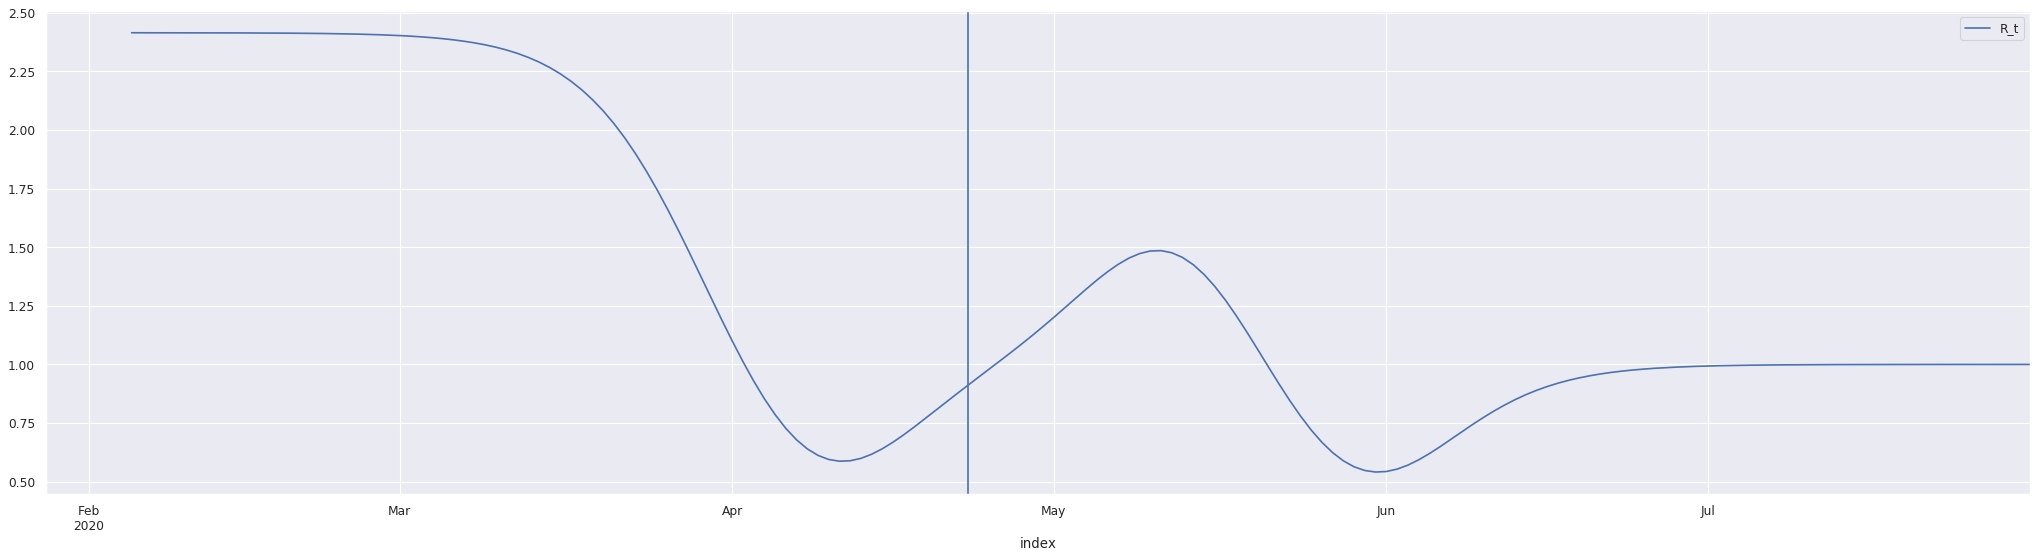

In [53]:
# ldf_R = calculate_R_from_fit_diff(ldf, label + '_fit_diff')
ldf_R = calculate_R_from_fit_diff(ldf, 'test_data_diff')
# ldf_R_pure_sig_fit_diff.iloc[-20:]

fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
dt = cbr_germany.df.index[-1]
ax.axvline(dt);
ldf_R[['R_t']].loc[dt]

R_t    0.448263
Name: 2020-04-23 00:00:00, dtype: float64

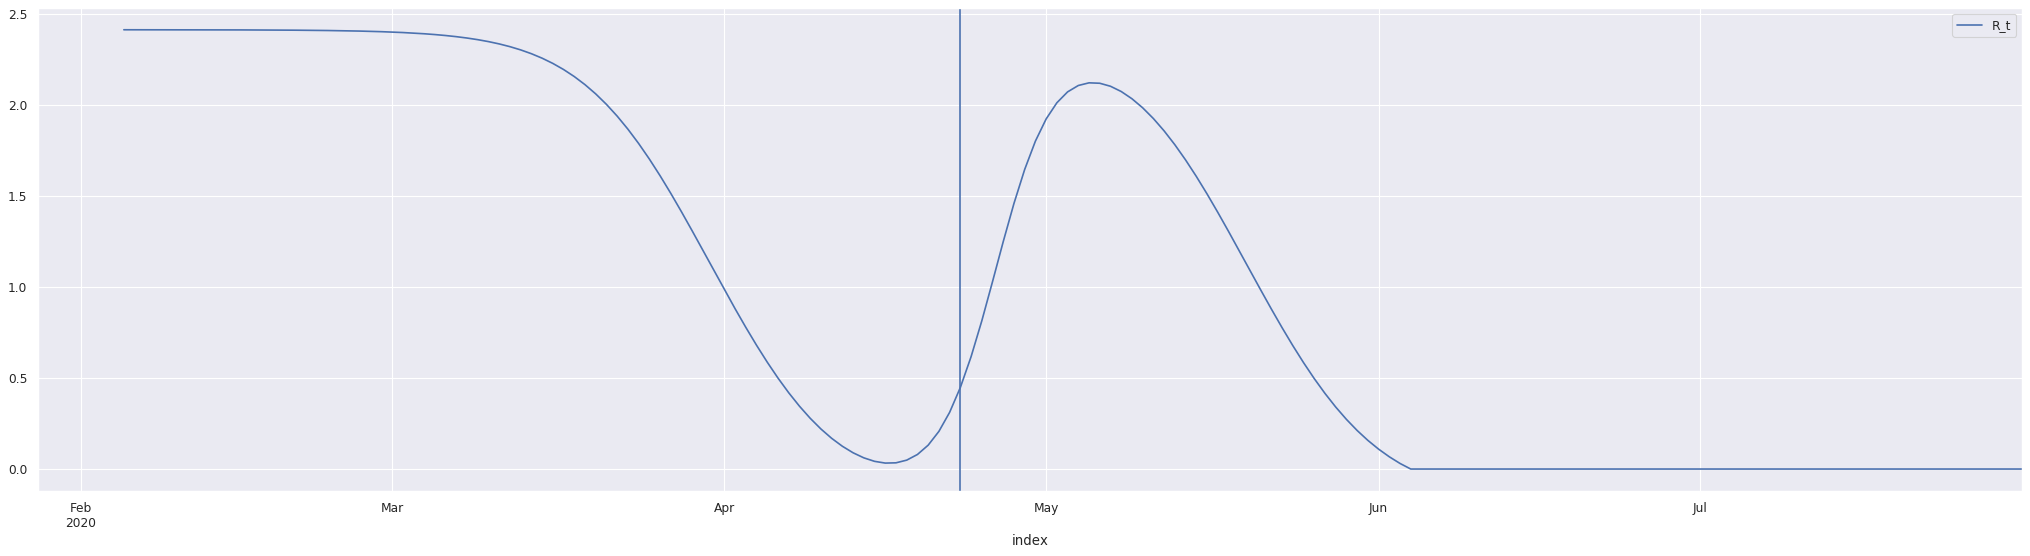

In [54]:
ldf['test_data1'] = covid19.fitSig(ldf.x, *lpopt[:3]) + covid19.fitSig(ldf.x-50, *lpopt[:3])
ldf['test_data1_diff'] = discrete_diff(ldf['test_data1'])
# ldf_R = calculate_R_from_fit_diff(ldf, label + '_fit_diff')
ldf_R = calculate_R_from_fit_diff(ldf, 'test_data1_diff')
# ldf_R_pure_sig_fit_diff.iloc[-20:]

fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
dt = cbr_germany.df.index[-1]
ax.axvline(dt);
ldf_R[['R_t']].loc[dt]

In [55]:
ldf

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit,test_data,test_data_diff,test_data1,test_data1_diff
index,,,,,,,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,0.162105,0.162105,NaN,1.838063,NaN,1.662738,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,1.790760,1.790760,NaN,2.209441,0.371379,1.998692,0.335954
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,1.344388,1.344388,NaN,2.655855,0.446413,2.402524,0.403832
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,4.807829,4.807829,NaN,3.192463,0.536608,2.887946,0.485423
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,4.162863,4.162863,NaN,3.837487,0.645025,3.471444,0.583497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004,NaN,-0.033683,NaN,440505.662187,1964.892222,202492.869654,0.042218
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004,NaN,-0.033421,NaN,442470.547312,1964.885126,202492.904775,0.035122
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003,NaN,-0.033158,NaN,444435.426534,1964.879222,202492.933994,0.029218


In [56]:
ldf1 = ldf.loc[:cbr_germany.df.index[-2]].copy()
ldf.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit,test_data,test_data_diff,test_data1,test_data1_diff
index,,,,,,,,,,,,,,
2020-07-27,182.0,NaN,339259.331812,1964.850008,NaN,101246.539279,0.000004,NaN,-0.033683,NaN,440505.662187,1964.892222,202492.869654,0.042218
2020-07-28,183.0,NaN,341224.181819,1964.850007,NaN,101246.539283,0.000004,NaN,-0.033421,NaN,442470.547312,1964.885126,202492.904775,0.035122
2020-07-29,184.0,NaN,343189.031826,1964.850007,NaN,101246.539286,0.000003,NaN,-0.033158,NaN,444435.426534,1964.879222,202492.933994,0.029218
2020-07-30,185.0,NaN,345153.881833,1964.850006,NaN,101246.539288,0.000002,NaN,-0.032896,NaN,446400.300845,1964.874311,202492.958301,0.024307
2020-07-31,186.0,NaN,347118.731838,1964.850006,NaN,101246.539290,0.000002,NaN,-0.032634,NaN,448365.171070,1964.870225,202492.978522,0.020221


In [57]:
np.sign(np.array([-1.0,0.0,1.0]))

array([-1.,  0.,  1.])

In [58]:
# -b*t -c == 0 => t = -c/b
# b1*t+c = b2*t+c2 at -c/b => c2=b2*c/b1
def fitSigAsymmetric(t, a, b1, b2, c):
    ti = b1*t+c
    negative  = (-np.sign(ti) + np.abs(np.sign(ti)))/2.0
    positive  = (np.sign(ti)  + np.abs(np.sign(ti)))/2.0
    b = negative * b1 + positive * b2
    c = negative * c + positive * b2/b1*c
    return a / (1.0 + np.exp(-b * t - c)) # , positive, negative, b


In [59]:
lpopt

array([101246.53930034,      0.18403068,    -11.20096323,  10676.75214898])

In [60]:
a, b, c = lpopt[:3]
covid19.fitSig(ldf1.x, a, b, c)

index
2020-01-28         1.662570
2020-01-29         1.998491
2020-01-30         2.402281
2020-01-31         2.887655
2020-02-01         3.471094
                  ...      
2020-04-18     99217.104085
2020-04-19     99552.523688
2020-04-20     99833.295685
2020-04-21    100068.082435
2020-04-22    100264.247092
Freq: D, Name: x, Length: 86, dtype: float64

In [61]:
fitSigAsymmetric(ldf1.x, a, b, b+0.1, c)

index
2020-01-28         1.662570
2020-01-29         1.998491
2020-01-30         2.402281
2020-01-31         2.887655
2020-02-01         3.471094
                  ...      
2020-04-18    100996.964698
2020-04-19    101058.559056
2020-04-20    101104.973396
2020-04-21    101139.939626
2020-04-22    101166.276188
Freq: D, Name: x, Length: 86, dtype: float64

In [62]:
daynr  = ldf1.x
values = ldf1.confirmed
p0 = [max(values) * 3 / 2, 0.2, -10]
fitFunc = covid19.fitSig
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([149583.70463332,      0.15452647,     -9.92476077]), 1947.426610852532)

* [How do I put a constraint on SciPy curve fit?](https://stackoverflow.com/questions/16541171/how-do-i-put-a-constraint-on-scipy-curve-fit)

In [63]:
daynr  = ldf1.x
values = ldf1.confirmed
p0 = [max(values) * 3 / 2, 0.2, 0.2, -10]
fitFunc = fitSigAsymmetric
popt, pcov = scipy.optimize.curve_fit(fitFunc, daynr, values,  p0)

seor = math.sqrt(sum((values - fitFunc(daynr, *(popt))) ** 2) / (len(daynr) - len(popt)))

popt, seor

(array([159119.27209199,      0.16323303,      0.11766111,    -10.51429907]),
 1515.6886116246467)

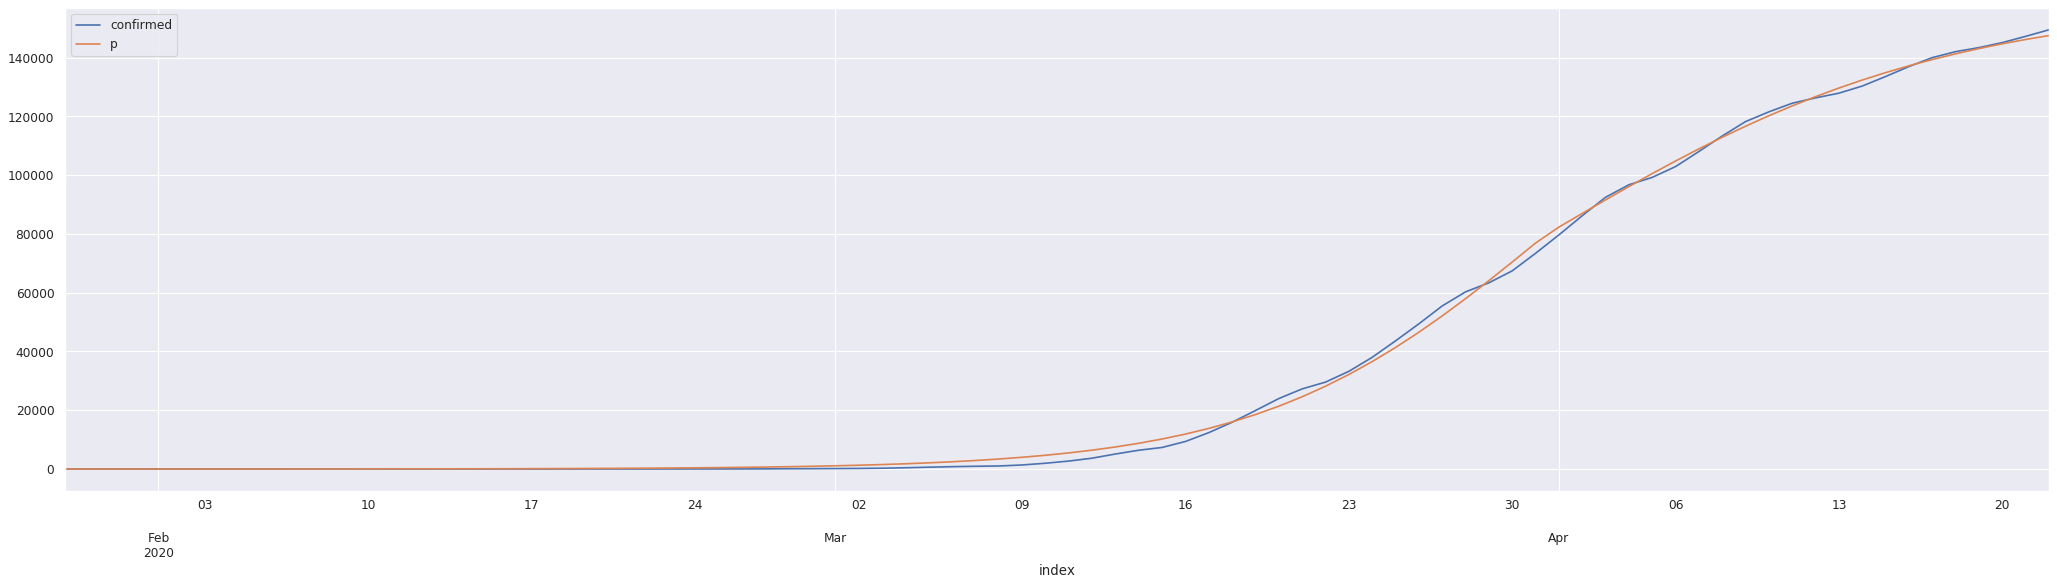

In [64]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf1['p'] = fitFunc(ldf1.x, *popt)
ldf1[['confirmed', 'p']].plot(ax=ax)

In [65]:
ldf1['p_diff'] = discrete_diff(ldf1['p'])

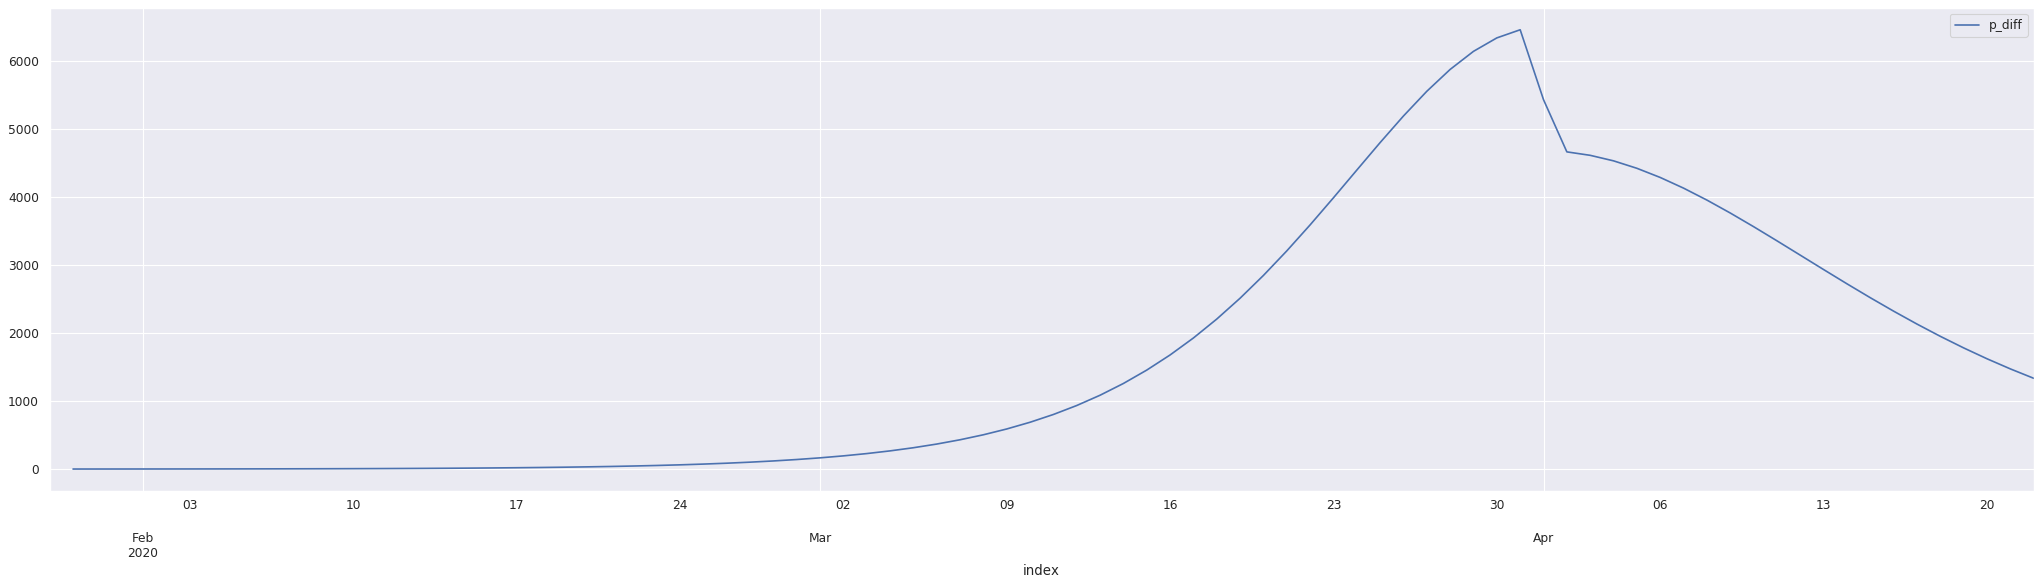

In [66]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf1[['p_diff']].plot(ax=ax)

* Kalman smoothing:
    * [plot_sin.py](https://github.com/pykalman/pykalman/blob/master/examples/standard/plot_sin.py)

In [68]:
rnd = np.random.RandomState(0)
n_timesteps = 100
x = np.linspace(0, 3 * np.pi, n_timesteps)
observations = 20 * (np.sin(x) + 0.5 * rnd.randn(n_timesteps))

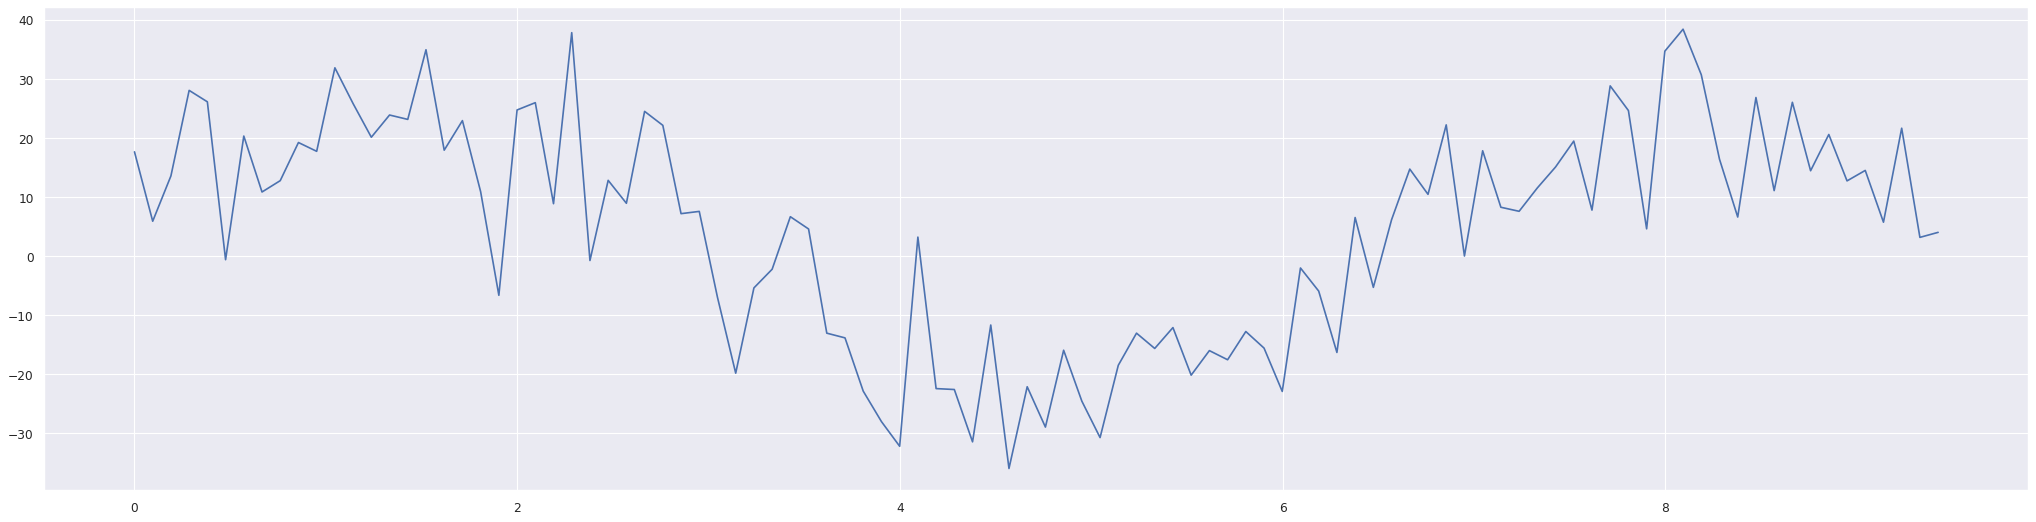

In [69]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(x, observations)

In [70]:
import simdkalman

In [82]:
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)

In [84]:
# fit noise parameters to data with the EM algorithm (optional)
kf = kf.em(observations, n_iter=10)

In [85]:
# smooth and explain existing data
smoothed = kf.smooth(observations)

In [86]:
pred = kf.predict(observations, 15)

In [87]:
pred.observations.mean

array([ 9.27227734,  8.35889269,  7.44550804,  6.53212339,  5.61873874,  4.70535409,  3.79196944,  2.87858478,  1.96520013,  1.05181548,  0.13843083, -0.77495382, -1.68833847, -2.60172312, -3.51510777])

In [88]:
observations

array([ 17.64052346,   5.90269295,  13.57240473,  28.04358313,  26.10882901,  -0.60824836,  20.31370052,  10.84960764,  12.76939171,  19.22097651,  17.73195475,  31.86324315,  25.80301716,  20.11676654,  23.87486369,  23.13317211,  34.91813752,  17.92576415,  22.92710585,  10.89527397,  -6.62988178,  24.72882586,  25.96487006,   8.86986884,  37.81253773,  -0.74207652,  12.8207649 ,   8.94097785,  24.49232258,  22.12683681,   7.18412539,   7.56665008,  -6.97673661, -19.80796468,  -5.38024236,  -2.2215352 ,   6.66825567,   4.59054937, -13.03779861, -13.83584385, -22.84870938, -28.0017596 , -32.17769339,   3.21623491, -22.41702989, -22.57338292, -31.42796997, -11.66132781, -35.93540731, -22.10474959, -28.9320124 , -15.92740386, -24.54428274, -30.70633822, -18.47446219, -13.03718937, -15.62634682, -12.09027251, -20.14480117, -15.99059138, -17.53742083, -12.76006205, -15.56471193, -22.89747716,  -2.01076346,  -5.91893023, -16.30198347,   6.52894342,  -5.28795876,   6.15410509,
        14.72

In [89]:
smoothed.observations.mean

array([  8.20768221,   9.70239429,  11.23961495,  12.70298878,  13.8738494 ,  14.79338781,  15.88767303,  16.84606556,  17.82224833,  18.79126058,  19.65423678,  20.43187622,  20.90416795,  21.16456386,  21.30233202,  21.26023252,  21.04920586,  20.48892171,  19.84477195,  19.04391387,  18.2731403 ,  17.79538393,  17.11056909,  16.1802738 ,  15.2496686 ,  13.85671326,  12.58062078,  11.19568072,   9.7400311 ,   7.95304545,   5.85577484,   3.66950377,   1.38237448,  -0.78824756,  -2.65732864,  -4.46816025,  -6.29439286,  -8.2949035 , -10.45191699, -12.50110845, -14.43496769, -16.12058511, -17.48809422, -18.48911359, -19.68564926, -20.69362217, -21.51618035, -22.02318049, -22.52452212, -22.65023882, -22.61709707, -22.32474993, -21.97660929, -21.44024113, -20.62015969, -19.70524392, -18.77752626, -17.79034317, -16.78624075, -15.6257355 , -14.3558793 , -12.93571009, -11.42122922,  -9.75152505,  -7.798458  ,  -5.8714313 ,  -3.89757322,  -1.70487384,   0.36491044,   2.50303106,
         4.54

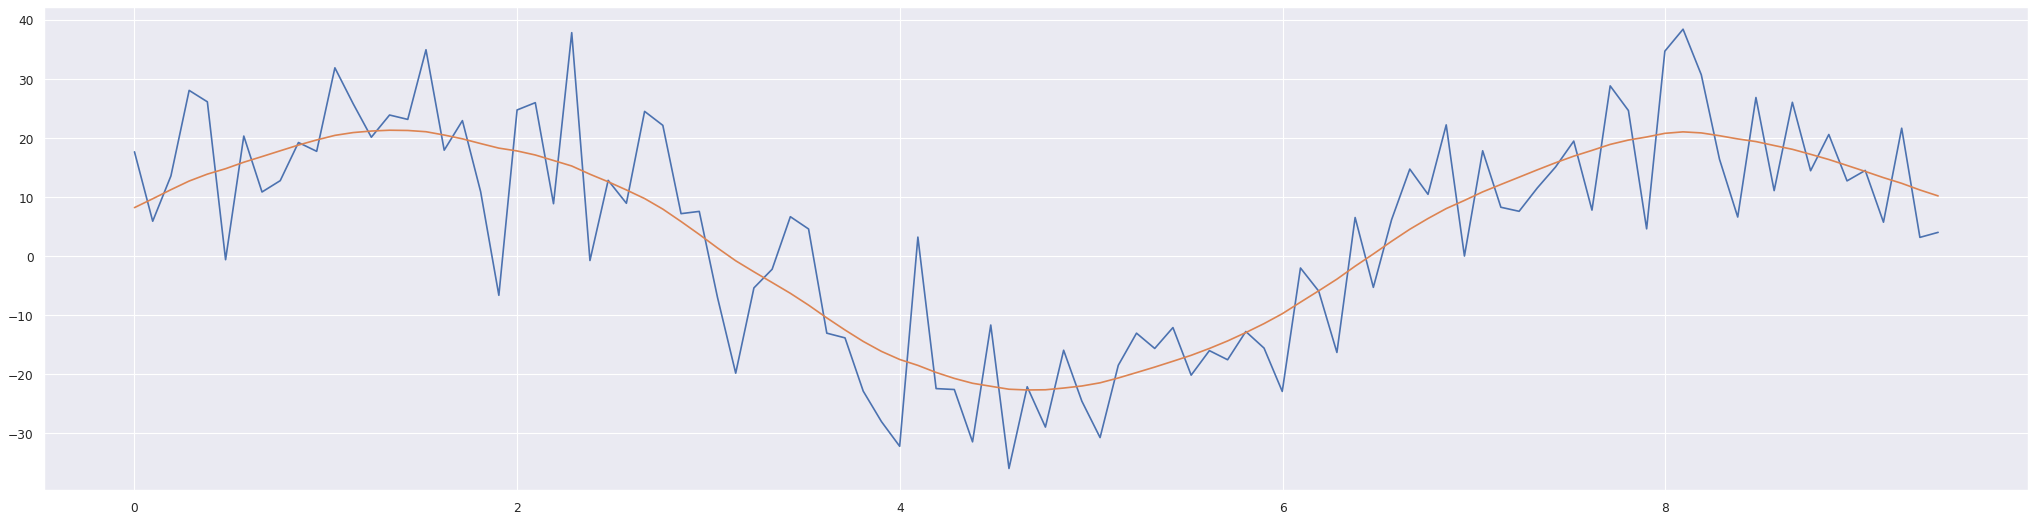

In [90]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ax.plot(x, observations)
ax.plot(x, smoothed.observations.mean)

In [93]:
kf.observation_noise

array([[[90.05907617]]])

In [94]:
kf.process_noise

array([[[ 1.27261595, -0.09702647],
        [-0.09702647,  0.0868868 ]]])

In [98]:
cbr_germany.df

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-01-28,2,2,0,2,2,0
2020-01-29,4,4,0,2,2,0
2020-01-30,4,4,0,0,0,0
2020-01-31,8,8,0,4,4,0
2020-02-01,8,8,0,0,0,0
...,...,...,...,...,...,...
2020-04-19,143386,106178,5227,1373,152,26
2020-04-20,145097,106353,5265,1711,175,38
2020-04-21,147220,106518,5293,2123,165,28


In [129]:
ldf = cbr_germany.df[['confirmed']].copy()
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)
kf = kf.em(ldf.confirmed, n_iter=10)
smoothed = kf.smooth(ldf.confirmed)
ldf['p'] = smoothed.observations.mean
ldf.tail()

,confirmed,p
index,,
2020-04-19,143386,143505.760298
2020-04-20,145097,145233.863586
2020-04-21,147220,147245.944878
2020-04-22,149456,149190.118361
2020-04-23,150316,150466.215315


In [130]:
kf.observation_noise, kf.process_noise

(array([[[101975.05079245]]]),
 array([[[ 45680.00935936, -54715.2640733 ],
         [-54715.2640733 , 275829.91908004]]]))

In [131]:
seor = math.sqrt(sum((ldf.p - ldf.confirmed) ** 2)) / (len(ldf) - 2)
seor

14.04028826146138

In [111]:
seor = math.sqrt(sum((ldf1.p - ldf1.confirmed) ** 2)) / (len(ldf1) - 2)
seor

163.39457294940428

(18330, 18344)

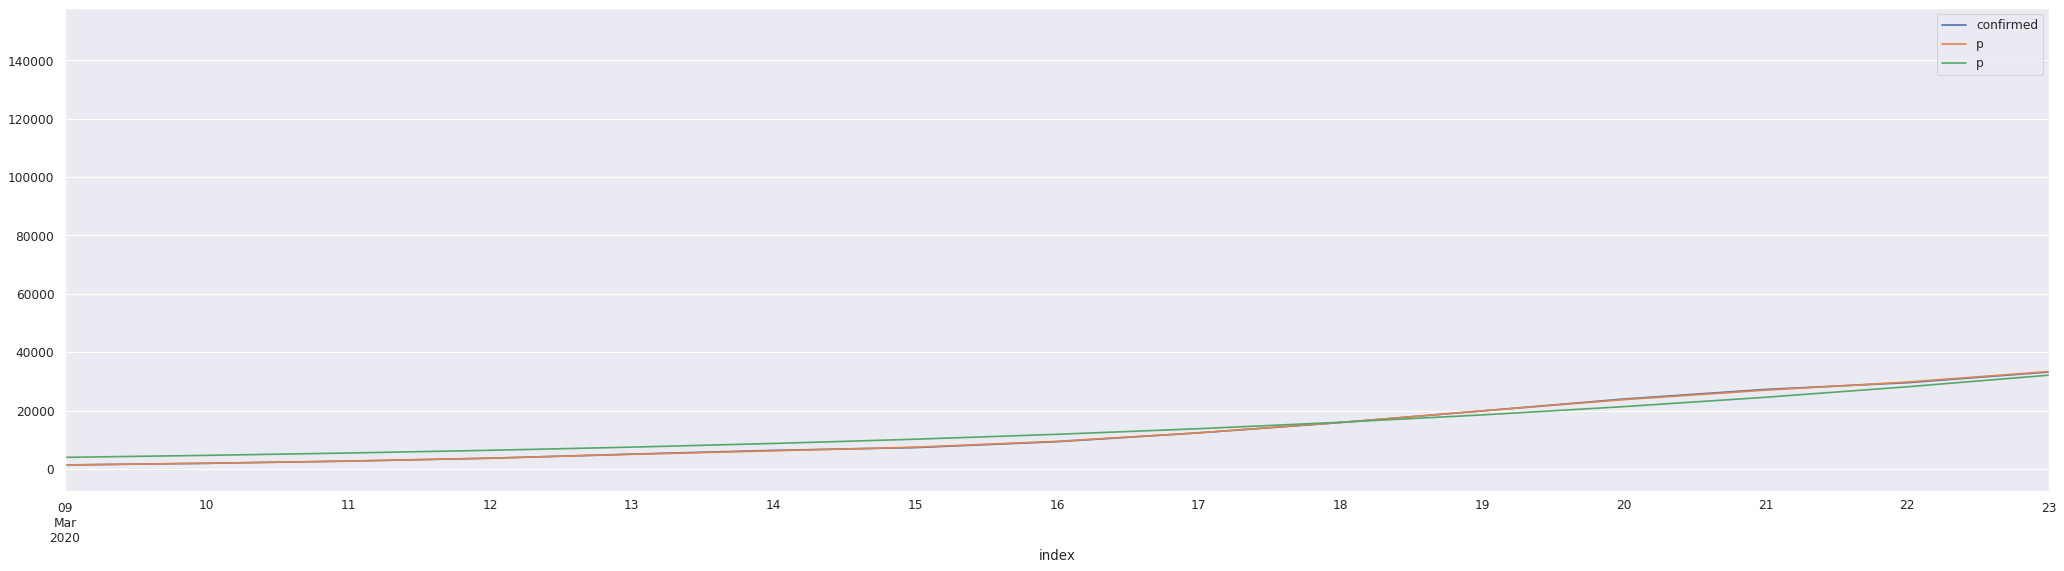

In [134]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', 'p']].plot(ax=ax)
ldf1[['p']].plot(ax=ax)
ax.set_xlim(pd.to_datetime('2020-03-09'), pd.to_datetime('2020-03-23'))

In [144]:
discrete_diff?

In [145]:
ldf['p_diff'] = discrete_diff(ldf['p'])
ldf

,confirmed,p,p_diff
index,,,
2020-01-28,2,0.001531,NaN
2020-01-29,4,1.010300,1.008769
2020-01-30,4,3.588190,2.577890
2020-01-31,8,6.872369,3.284178
2020-02-01,8,7.871213,0.998844
...,...,...,...
2020-04-19,143386,143505.760298,1588.477279
2020-04-20,145097,145233.863586,1728.103288
2020-04-21,147220,147245.944878,2012.081291


R_t    0.835177
Name: 2020-04-21 00:00:00, dtype: float64

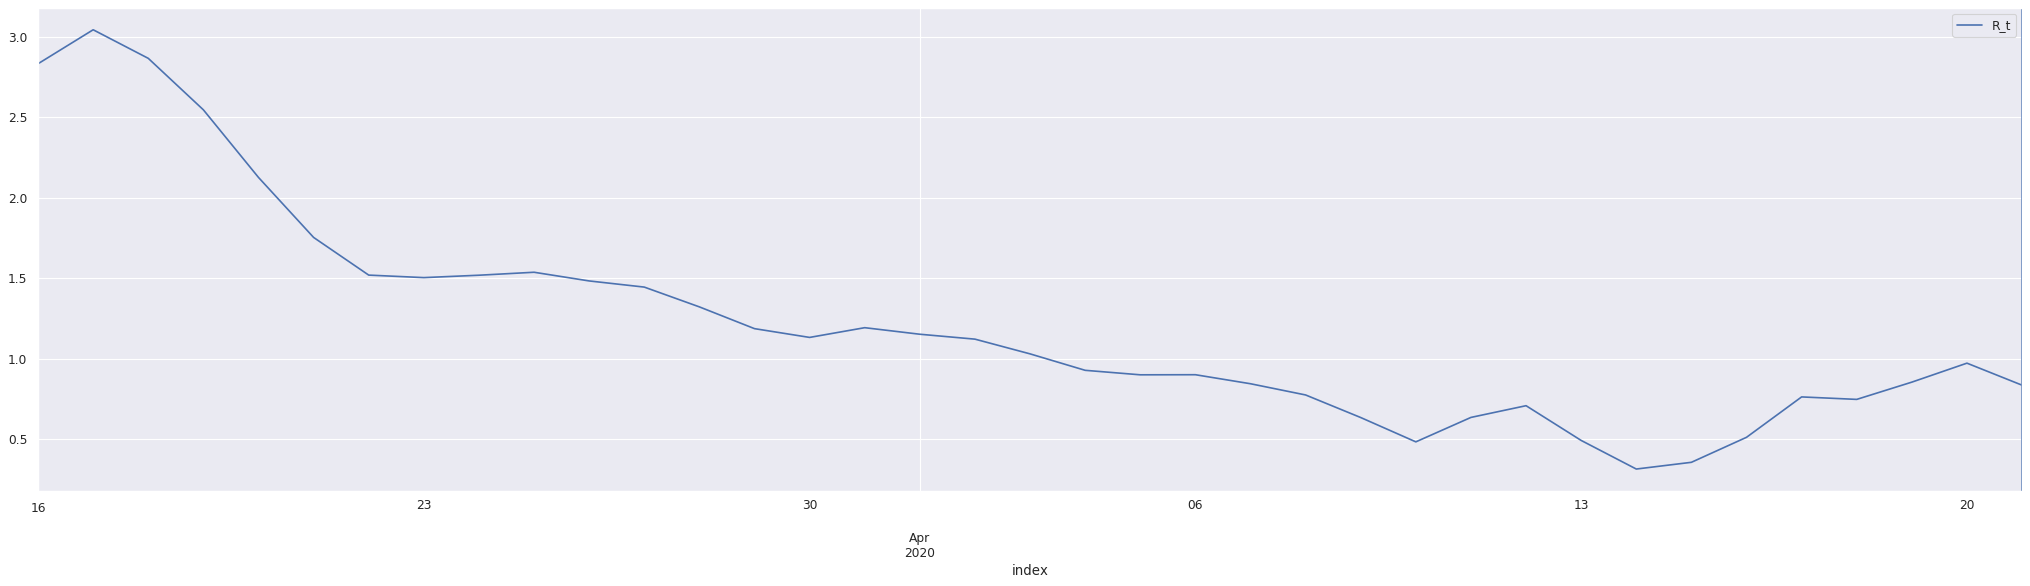

In [169]:
ldf_R = calculate_R_from_fit_diff(ldf, 'p_diff')
ldf_R = ldf_R.loc[pd.to_datetime('2020-03-16'):pd.to_datetime('2020-04-21')]

fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
dt = ldf_R.index[-1]
ax.axvline(dt);
ldf_R[['R_t']].loc[dt]

In [171]:
ldf_R

,v,I_t,dI_t,gr_It,R_t
index,,,,,
2020-03-16,2012.070856,8088.920462,1677.665963,0.261675,2.831726
2020-03-17,2921.408618,10449.501265,2360.580803,0.291829,3.042802
2020-03-18,3550.441365,13233.926857,2784.425592,0.266465,2.865254
2020-03-19,3936.547062,16155.614766,2921.687909,0.220773,2.545408
2020-03-20,3872.858556,18753.276834,2597.662068,0.160790,2.125530
2020-03-21,3247.074899,20770.283407,2017.006573,0.107555,1.752884
2020-03-22,2769.490132,22309.891488,1539.608081,0.074126,1.518879
2020-03-23,3616.201612,23914.022244,1604.130755,0.071902,1.503316
2020-03-24,4691.694746,25684.308372,1770.286128,0.074027,1.518190


In [175]:
ldf = ldf_R[['gr_It']].copy()
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)
kf = kf.em(ldf.gr_It, n_iter=10)
smoothed = kf.smooth(ldf.gr_It)
ldf['gr_It_smooth'] = smoothed.observations.mean
gamma = 1/7
lda_R = np.maximum(1.0 + 1/gamma * ldf['gr_It_smooth'],0.0)
ldf['R_t'] = lda_R
ldf.tail()

,gr_It,gr_It_smooth,R_t
index,,,
2020-04-17,-0.033964,-0.041227,0.711414
2020-04-18,-0.036155,-0.032720,0.770960
2020-04-19,-0.020847,-0.020026,0.859821
2020-04-20,-0.004007,-0.010184,0.928715
2020-04-21,-0.023546,-0.019432,0.863979


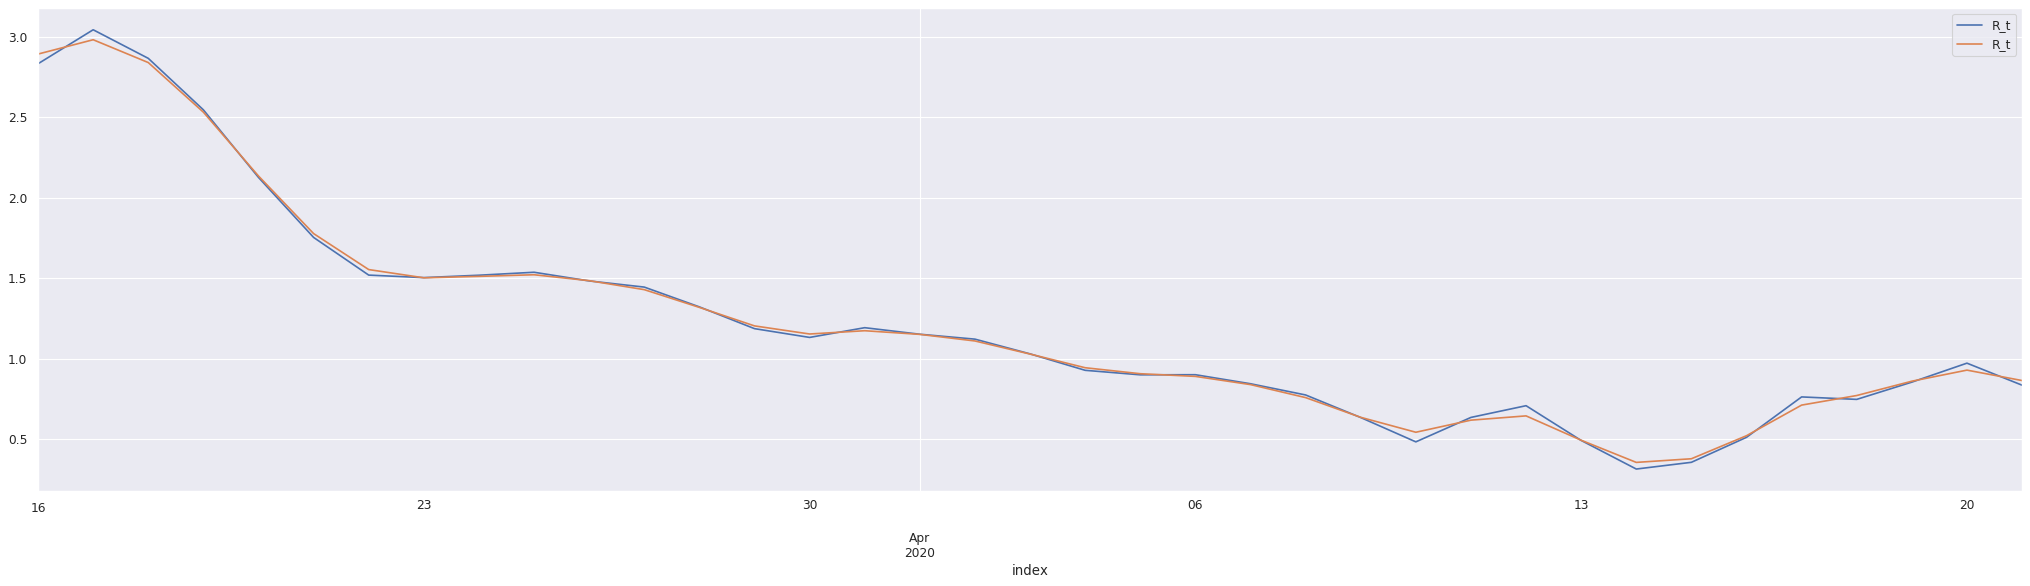

In [176]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
ldf[['R_t']].plot(ax=ax)

In [170]:
ldf1

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff,confirmed_diff,pure_sig_fit,pure_sig_fit_diff,confirmed_sigmoid+linear_fit_delta,gp_fit_,gp_fit,test_data,test_data_diff,test_data1,test_data1_diff,p,p_diff
index,,,,,,,,,,,,,,,,
2020-01-28,1.0,2.0,1.837895,0.000000,0.0,1.662570,NaN,0.162105,0.162105,NaN,1.838063,NaN,1.662738,NaN,5.085083,NaN
2020-01-29,2.0,4.0,2.209240,0.371345,2.0,1.998491,0.335920,1.790760,1.790760,NaN,2.209441,0.371379,1.998692,0.335954,5.986690,0.901607
2020-01-30,3.0,4.0,2.655612,0.446373,0.0,2.402281,0.403791,1.344388,1.344388,NaN,2.655855,0.446413,2.402524,0.403832,7.048149,1.061459
2020-01-31,4.0,8.0,3.192171,0.536559,4.0,2.887655,0.485374,4.807829,4.807829,NaN,3.192463,0.536608,2.887946,0.485423,8.297799,1.249649
2020-02-01,5.0,8.0,3.837137,0.644966,0.0,3.471094,0.583439,4.162863,4.162863,NaN,3.837487,0.645025,3.471444,0.583497,9.768999,1.471201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-18,82.0,142013.0,140961.080213,2321.908722,2025.0,99217.104085,400.212699,1051.919787,1051.919787,NaN,141457.991967,2405.093167,99714.015839,483.397144,141279.783353,1950.452493
2020-04-19,83.0,143386.0,143225.316193,2264.235979,1373.0,99552.523688,335.419603,160.683807,160.683807,NaN,143822.038564,2364.046597,100149.246060,435.230221,143060.160304,1780.376951
2020-04-20,84.0,145097.0,145440.868503,2215.552310,1711.0,99833.295685,280.771997,-343.868503,-343.868503,NaN,146157.307074,2335.268510,100549.734257,400.488197,144681.014383,1620.854079


In [ ]:
# ldf_R = calculate_R_from_fit_diff(ldf, label + '_fit_diff')
ldf_R = calculate_R_from_fit_diff(ldf1, 'p')
# ldf_R_pure_sig_fit_diff.iloc[-20:]

fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
dt = cbr_germany.df.index[-1]
ax.axvline(dt);
ldf_R[['R_t']].loc[dt]

In [177]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [181]:
ldf = ldf_R[['gr_It']].copy()
mod_ll = sm.tsa.UnobservedComponents(ldf['gr_It'], 'local level')
res_ll = mod_ll.fit(maxiter = 200, disp = False)
ldf['gr_It_smooth'] = res_ll.smoothed_state[0]
gamma = 1/7
lda_R = np.maximum(1.0 + 1/gamma * ldf['gr_It_smooth'],0.0)
ldf['R_t'] = lda_R
ldf.tail()

,gr_It,gr_It_smooth,R_t
index,,,
2020-04-17,-0.033964,-0.033964,0.762251
2020-04-18,-0.036155,-0.036155,0.746914
2020-04-19,-0.020847,-0.020847,0.854072
2020-04-20,-0.004007,-0.004007,0.971948
2020-04-21,-0.023546,-0.023546,0.835177


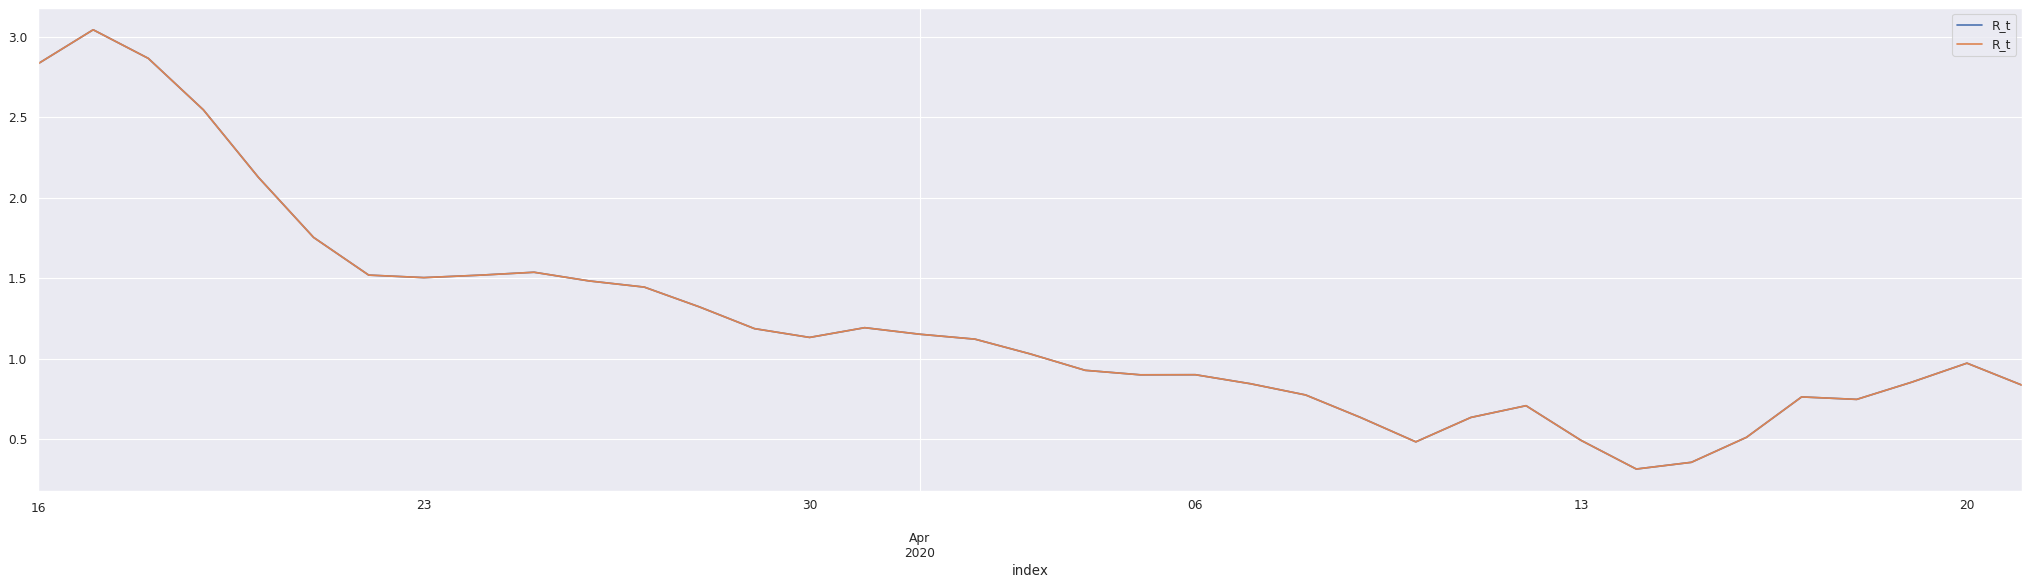

In [182]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R[['R_t']].plot(ax=ax)
ldf[['R_t']].plot(ax=ax)

In [249]:
average_infectious_period=7.0
gamma = 1/average_infectious_period
def I_from_new_confirmed(in_df, column_name='new_confirmed', average_infectious_period=7.0):
    rdf = pd.DataFrame(index=in_df.index)
    
    gamma = 1 / average_infectious_period
    ws = int(average_infectious_period)
    if ws < average_infectious_period:
        ws += 1
    rdf['x'] = np.arange(len(in_df)) * 1.0
    rdf['v'] = in_df[column_name]
    rdf['I_t'] = in_df[column_name].rolling(window=ws).sum()#, min_periods=1
    
    rdf = rdf.iloc[:-2].copy()
    
    return rdf

In [250]:
ldf_I = I_from_new_confirmed(cbr_germany.df)
ldf_I.tail()

,x,v,I_t
index,,,
2020-04-17,80.0,3036,18448.0
2020-04-18,81.0,2025,17545.0
2020-04-19,82.0,1373,17095.0
2020-04-20,83.0,1711,17210.0
2020-04-21,84.0,2123,16904.0


In [251]:
def discrete_division(in_da, first_value=np.nan):
    in_da = np.array(in_da)
    return np.concatenate([np.array([first_value]), in_da[1:] / in_da[:-1]])

In [252]:
# qI = quotient I = I_t/I_t-1
ldf_I['qI'] = discrete_division(ldf_I['I_t'])
ldf_I.tail()

,x,v,I_t,qI
index,,,,
2020-04-17,80.0,3036,18448.0,0.985260
2020-04-18,81.0,2025,17545.0,0.951052
2020-04-19,82.0,1373,17095.0,0.974352
2020-04-20,83.0,1711,17210.0,1.006727
2020-04-21,84.0,2123,16904.0,0.982220


In [253]:
ldf_I['lnqI'] = np.log(ldf_I['qI'])
ldf_I.tail()

,x,v,I_t,qI,lnqI
index,,,,,
2020-04-17,80.0,3036,18448.0,0.985260,-0.014850
2020-04-18,81.0,2025,17545.0,0.951052,-0.050187
2020-04-19,82.0,1373,17095.0,0.974352,-0.025983
2020-04-20,83.0,1711,17210.0,1.006727,0.006705
2020-04-21,84.0,2123,16904.0,0.982220,-0.017940


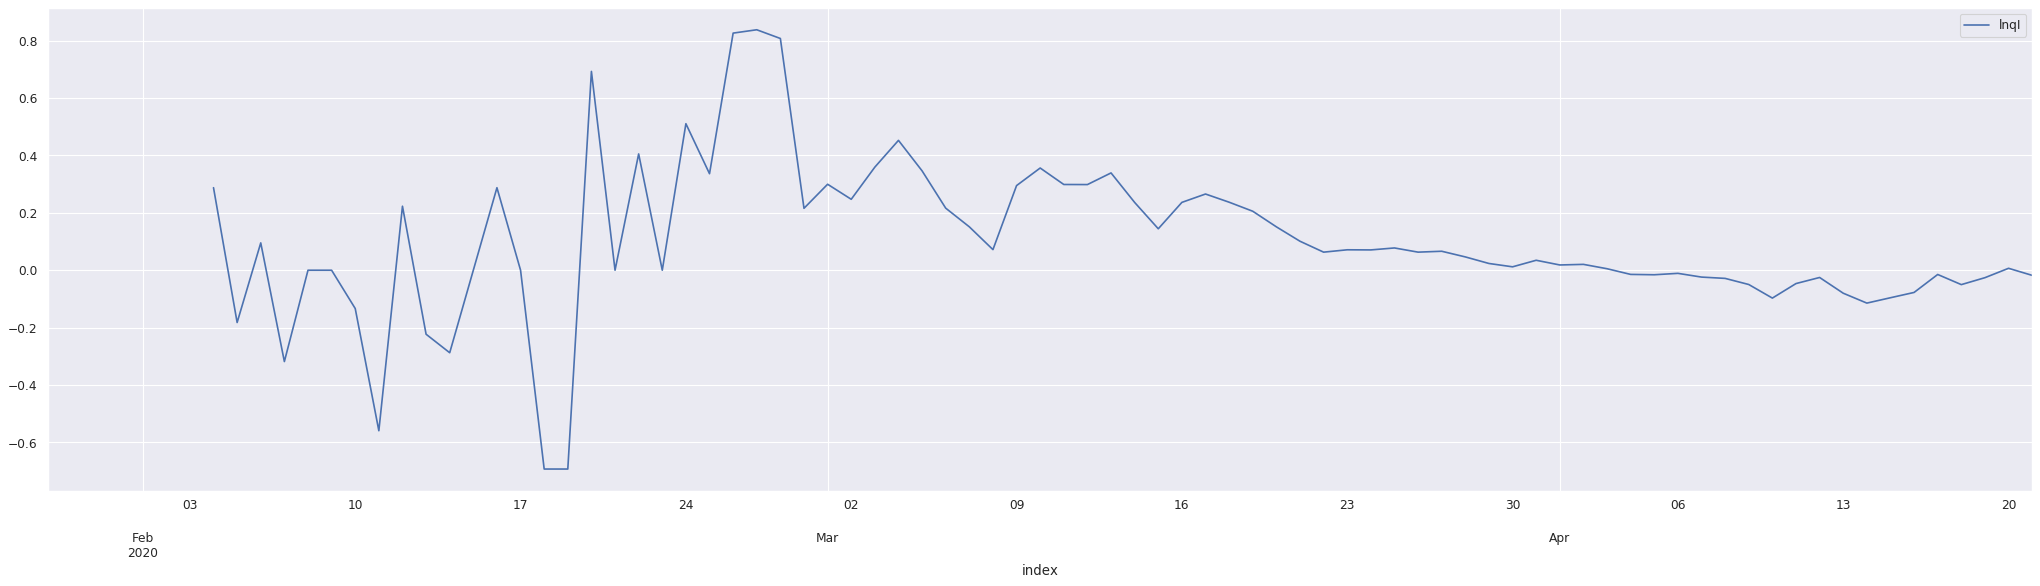

In [254]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_I[['lnqI']].plot(ax=ax)

In [255]:
ldf = ldf_I[~pd.isnull(ldf_I.lnqI)]
X = ldf.x.values.reshape(-1,1)
Y = ldf.lnqI.values.reshape(-1,1)
# Y = ldf1.confirmed.values.reshape(-1,1)

k1 = gpflow.kernels.RBF(variance=1.0, lengthscales=1.0)
kernel = k1

m = gpflow.models.GPR(data=(X, Y), kernel=kernel, noise_variance=1.0)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss,variables=m.trainable_variables,options=dict(disp=True), compile=False) #'Nelder-Mead', method='trust-exact', , maxiter=30
ldf_I['gp_lnqI'] = m.predict_f(ldf_I.x.values.reshape(-1,1))[0].numpy().reshape(-1)
ldf_I.tail()

,x,v,I_t,qI,lnqI,gp_lnqI
index,,,,,,
2020-04-17,80.0,3036,18448.0,0.985260,-0.014850,-0.047330
2020-04-18,81.0,2025,17545.0,0.951052,-0.050187,-0.039999
2020-04-19,82.0,1373,17095.0,0.974352,-0.025983,-0.032174
2020-04-20,83.0,1711,17210.0,1.006727,0.006705,-0.024360
2020-04-21,84.0,2123,16904.0,0.982220,-0.017940,-0.017006


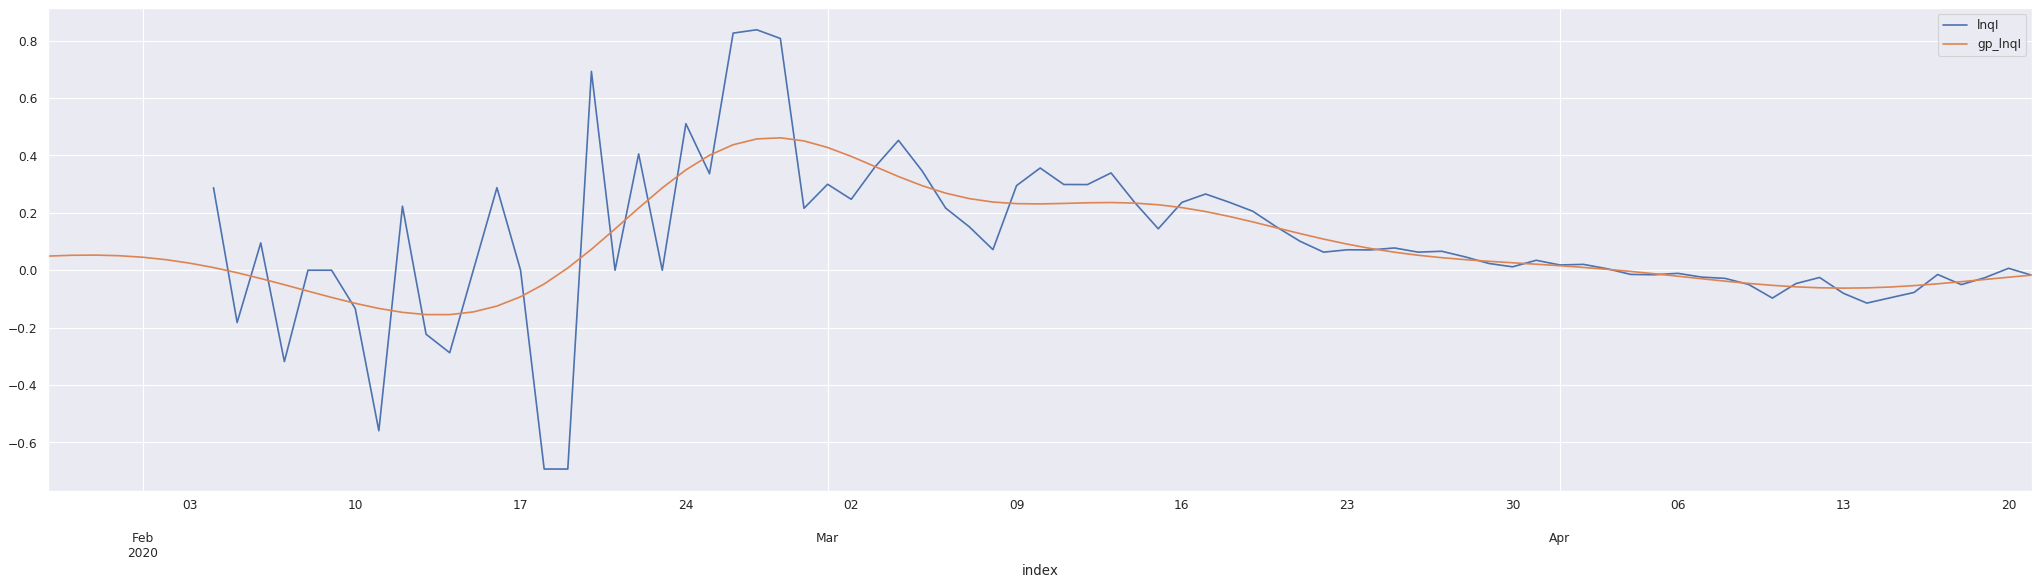

In [256]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_I[['lnqI', 'gp_lnqI']].plot(ax=ax)

In [257]:
kf = simdkalman.KalmanFilter(
    state_transition = np.array([[1,1],[0,1]]),
    process_noise = np.diag([0.1, 0.01]),
    observation_model = np.array([[1,0]]),
    observation_noise = 1.0)
kf = kf.em(ldf_I.lnqI, n_iter=10)
smoothed = kf.smooth(ldf.lnqI)
ldf_I['kf_lnqI'] = np.nan
v = smoothed.observations.mean
ldf_I['kf_lnqI'].iloc[len(ldf_I)-len(v):] = v
ldf.tail()

 /home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x,v,I_t,qI,lnqI
index,,,,,
2020-04-17,80.0,3036,18448.0,0.985260,-0.014850
2020-04-18,81.0,2025,17545.0,0.951052,-0.050187
2020-04-19,82.0,1373,17095.0,0.974352,-0.025983
2020-04-20,83.0,1711,17210.0,1.006727,0.006705
2020-04-21,84.0,2123,16904.0,0.982220,-0.017940


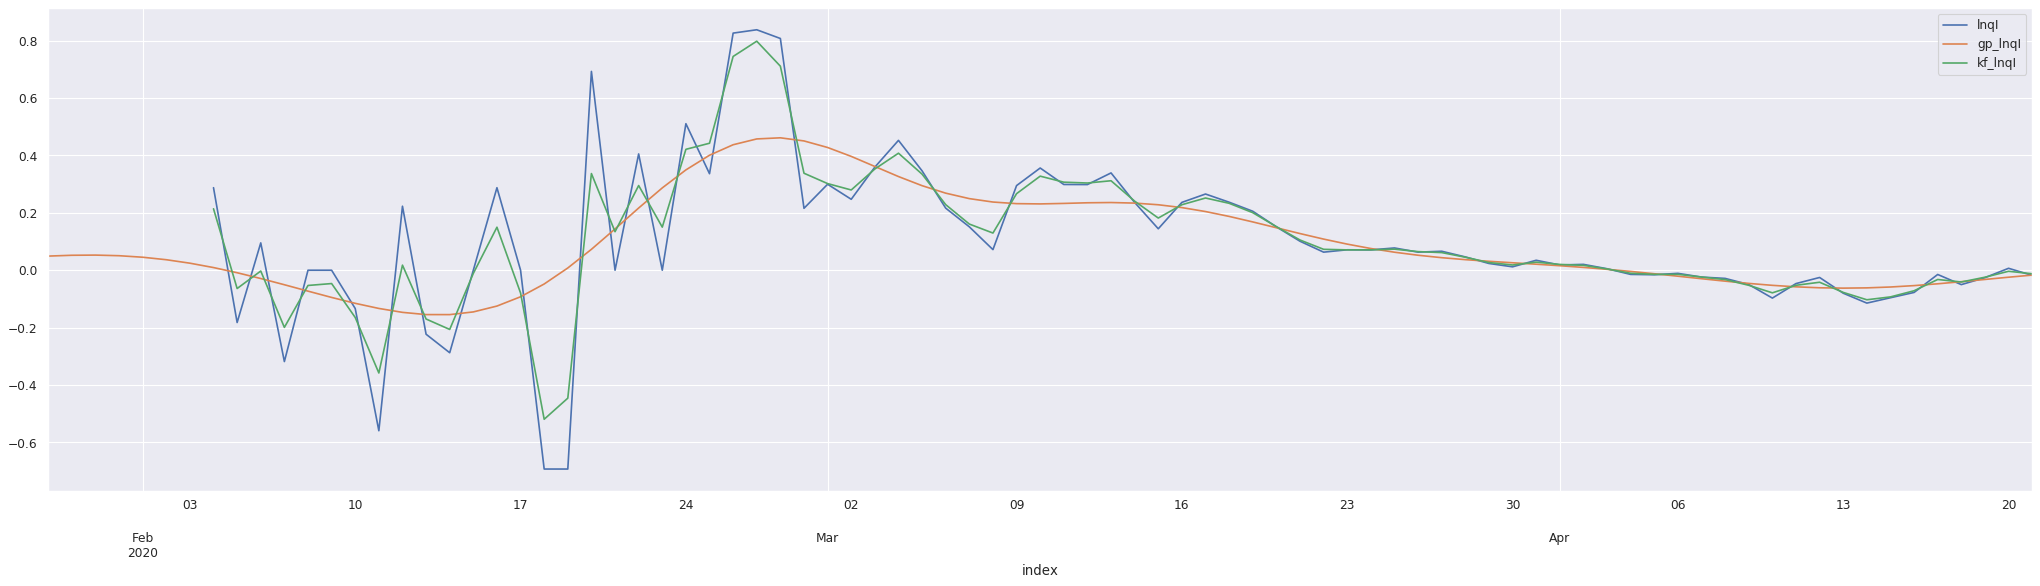

In [258]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_I[['lnqI', 'gp_lnqI', 'kf_lnqI']].plot(ax=ax)

In [259]:
mod_ll = sm.tsa.UnobservedComponents(ldf_I['lnqI'], 'local level')
res_ll = mod_ll.fit(maxiter = 200, disp = False)
ldf_I['ll_lnqI'] = res_ll.smoothed_state[0]
ldf_I.tail()

,x,v,I_t,qI,lnqI,gp_lnqI,kf_lnqI,ll_lnqI
index,,,,,,,,
2020-04-17,80.0,3036,18448.0,0.985260,-0.014850,-0.047330,-0.032313,-0.046303
2020-04-18,81.0,2025,17545.0,0.951052,-0.050187,-0.039999,-0.041032,-0.040653
2020-04-19,82.0,1373,17095.0,0.974352,-0.025983,-0.032174,-0.024396,-0.033700
2020-04-20,83.0,1711,17210.0,1.006727,0.006705,-0.024360,-0.003669,-0.027801
2020-04-21,84.0,2123,16904.0,0.982220,-0.017940,-0.017006,-0.012384,-0.026616


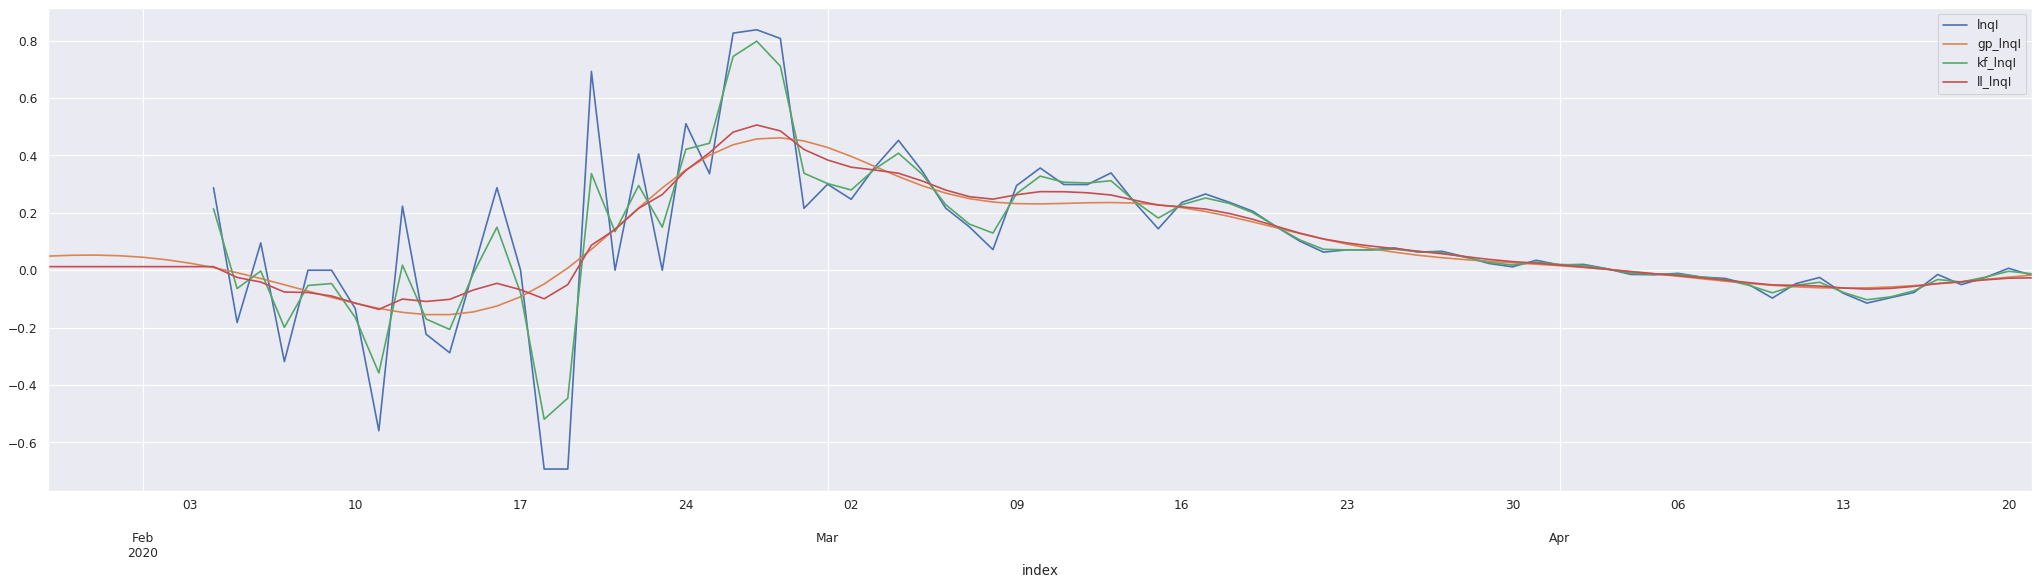

In [260]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_I[['lnqI', 'gp_lnqI', 'kf_lnqI', 'll_lnqI']].plot(ax=ax)

In [264]:
ldf_R = ldf_I[['lnqI', 'gp_lnqI', 'kf_lnqI', 'll_lnqI']].copy()
ldf_R.columns = ['R', 'gp_R', 'kf_R', 'll_R']
ldf_R = np.exp(ldf_R) - 1

ldf_R = np.maximum(1.0 + 1/gamma * ldf_R,0.0)

ldf_R.tail()

,R,gp_R,kf_R,ll_R
index,,,,
2020-04-17,0.896817,0.676407,0.777425,0.683268
2020-04-18,0.657361,0.725532,0.718589,0.721139
2020-04-19,0.820462,0.778365,0.831294,0.768033
2020-04-20,1.047090,0.831541,0.974362,0.808074
2020-04-21,0.875537,0.881965,0.913844,0.816147


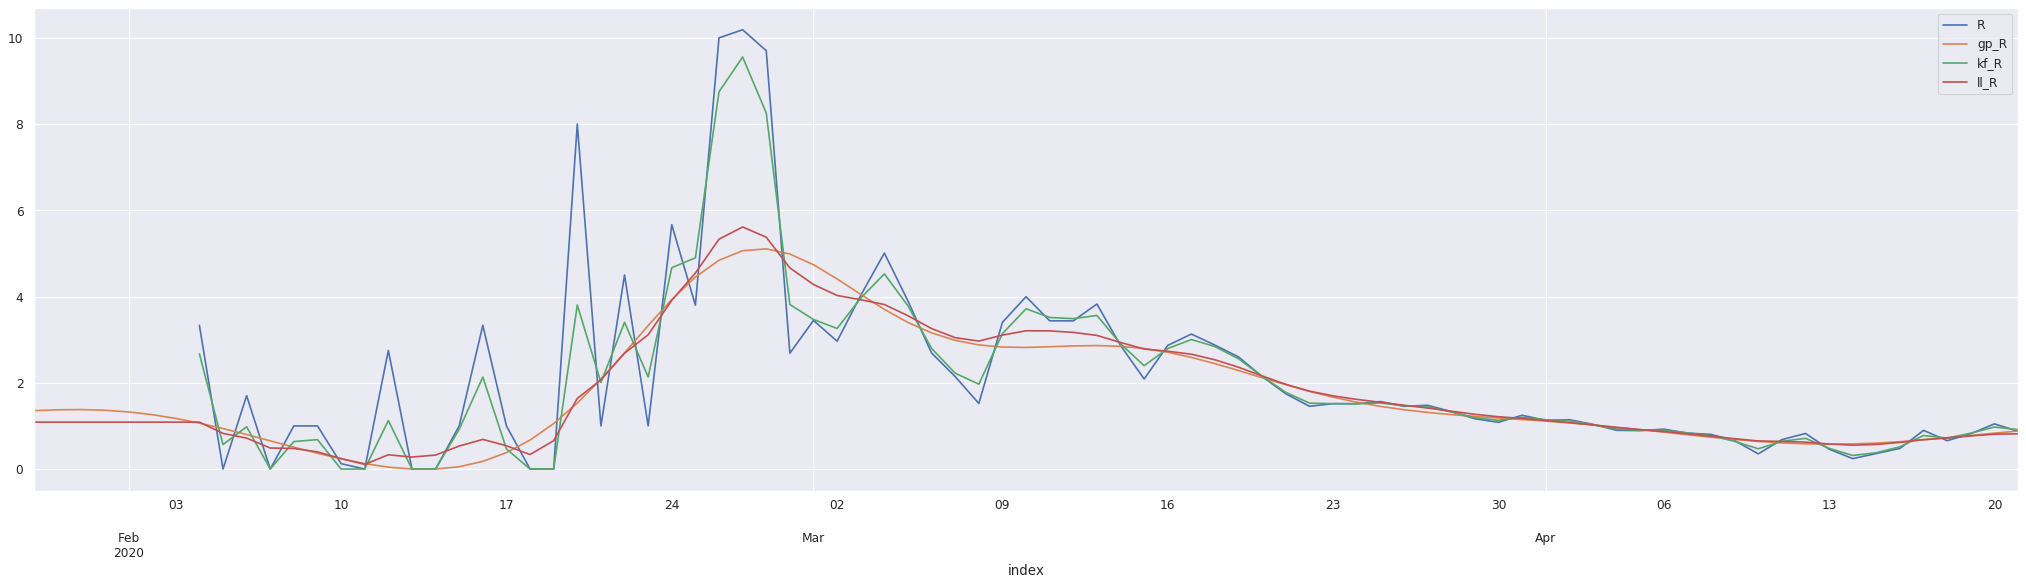

In [266]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R.plot(ax=ax)

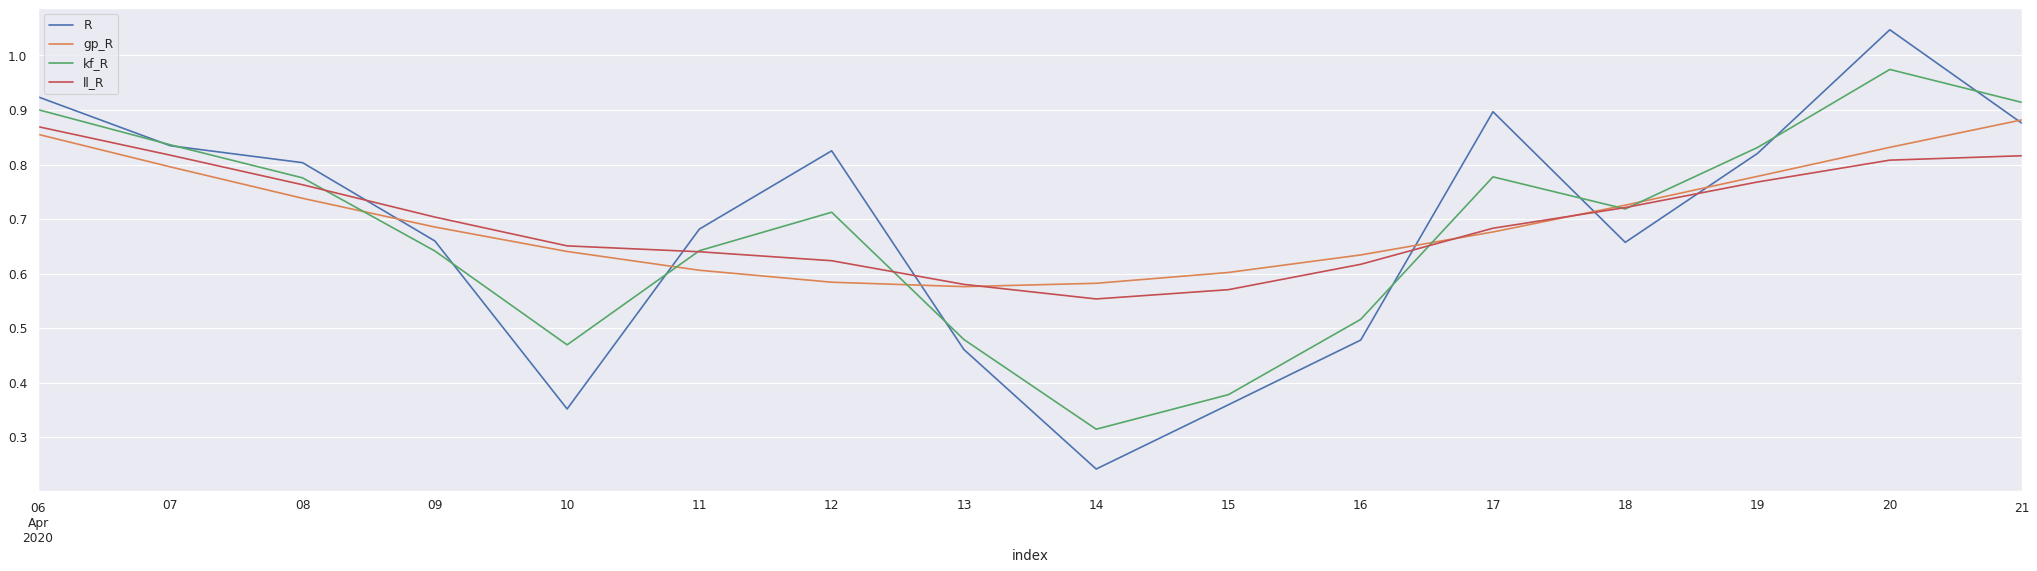

In [265]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf_R.loc[pd.to_datetime('2020-04-06'):].plot(ax=ax)